# Restaurant Location Opportunity Score - Data Preprocessing

This notebook preprocesses Yelp business/review data and US Census demographic data to create features for predicting restaurant success at the zip code level.


In [1]:
# FIRST CELL - Upgrade scikit-learn to match local environment
!pip install --upgrade scikit-learn==1.7.2 joblib --quiet
print("✓ Upgraded scikit-learn to 1.7.2")

# Restart runtime to load new versions
import IPython
print("⚠️  RESTART RUNTIME NOW: Runtime > Restart runtime")
print("Then run all cells again from the top")

✓ Upgraded scikit-learn to 1.7.2
⚠️  RESTART RUNTIME NOW: Runtime > Restart runtime
Then run all cells again from the top


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Import Libraries


In [3]:
import pandas as pd
import numpy as np
import json
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')

print("Libraries imported successfully")


Libraries imported successfully


## Load Yelp Business Data


In [4]:
# Load Yelp business data
business_file = '/content/drive/MyDrive/CSE 6242 Project/yelp_dataset/yelp_academic_dataset_business.json'
businesses = []

with open(business_file, 'r', encoding='utf-8') as f:
    for line in f:
        businesses.append(json.loads(line))

df_business = pd.DataFrame(businesses)
print(f"Loaded {len(df_business)} businesses")
print(f"Columns: {df_business.columns.tolist()}")
df_business.head()


Loaded 150346 businesses
Columns: ['business_id', 'name', 'address', 'city', 'state', 'postal_code', 'latitude', 'longitude', 'stars', 'review_count', 'is_open', 'attributes', 'categories', 'hours']


,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
0,Pns2l4eNsfO8kk83dixA6A,"Abby Rappoport, LAC, CMQ","1616 Chapala St, Ste 2",Santa Barbara,CA,93101,34.426679,-119.711197,5.0,7,0,{'ByAppointmentOnly': 'True'},"Doctors, Traditional Chinese Medicine, Naturop...",None
1,mpf3x-BjTdTEA3yCZrAYPw,The UPS Store,87 Grasso Plaza Shopping Center,Affton,MO,63123,38.551126,-90.335695,3.0,15,1,{'BusinessAcceptsCreditCards': 'True'},"Shipping Centers, Local Services, Notaries, Ma...","{'Monday': '0:0-0:0', 'Tuesday': '8:0-18:30', ..."
2,tUFrWirKiKi_TAnsVWINQQ,Target,5255 E Broadway Blvd,Tucson,AZ,85711,32.223236,-110.880452,3.5,22,0,"{'BikeParking': 'True', 'BusinessAcceptsCredit...","Department Stores, Shopping, Fashion, Home & G...","{'Monday': '8:0-22:0', 'Tuesday': '8:0-22:0', ..."
3,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,935 Race St,Philadelphia,PA,19107,39.955505,-75.155564,4.0,80,1,"{'RestaurantsDelivery': 'False', 'OutdoorSeati...","Restaurants, Food, Bubble Tea, Coffee & Tea, B...","{'Monday': '7:0-20:0', 'Tuesday': '7:0-20:0', ..."
4,mWMc6_wTdE0EUBKIGXDVfA,Perkiomen Valley Brewery,101 Walnut St,Green Lane,PA,18054,40.338183,-75.471659,4.5,13,1,"{'BusinessAcceptsCreditCards': 'True', 'Wheelc...","Brewpubs, Breweries, Food","{'Wednesday': '14:0-22:0', 'Thursday': '16:0-2..."


## Filter for Restaurants Only


In [5]:
# Filter for restaurants
df_business['categories'] = df_business['categories'].fillna('')
restaurant_keywords = ['restaurant', 'restaurants', 'food', 'pizza', 'burger', 'cafe', 'bar', 'grill', 'diner', 'bistro', 'eatery']
df_restaurants = df_business[df_business['categories'].str.lower().str.contains('|'.join(restaurant_keywords))].copy()

print(f"Filtered to {len(df_restaurants)} restaurants")
df_restaurants.head()


Filtered to 68738 restaurants


,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
3,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,935 Race St,Philadelphia,PA,19107,39.955505,-75.155564,4.0,80,1,"{'RestaurantsDelivery': 'False', 'OutdoorSeati...","Restaurants, Food, Bubble Tea, Coffee & Tea, B...","{'Monday': '7:0-20:0', 'Tuesday': '7:0-20:0', ..."
4,mWMc6_wTdE0EUBKIGXDVfA,Perkiomen Valley Brewery,101 Walnut St,Green Lane,PA,18054,40.338183,-75.471659,4.5,13,1,"{'BusinessAcceptsCreditCards': 'True', 'Wheelc...","Brewpubs, Breweries, Food","{'Wednesday': '14:0-22:0', 'Thursday': '16:0-2..."
5,CF33F8-E6oudUQ46HnavjQ,Sonic Drive-In,615 S Main St,Ashland City,TN,37015,36.269593,-87.058943,2.0,6,1,"{'BusinessParking': 'None', 'BusinessAcceptsCr...","Burgers, Fast Food, Sandwiches, Food, Ice Crea...","{'Monday': '0:0-0:0', 'Tuesday': '6:0-22:0', '..."
8,k0hlBqXX-Bt0vf1op7Jr1w,Tsevi's Pub And Grill,8025 Mackenzie Rd,Affton,MO,63123,38.565165,-90.321087,3.0,19,0,"{'Caters': 'True', 'Alcohol': 'u'full_bar'', '...","Pubs, Restaurants, Italian, Bars, American (Tr...",None
9,bBDDEgkFA1Otx9Lfe7BZUQ,Sonic Drive-In,2312 Dickerson Pike,Nashville,TN,37207,36.208102,-86.768170,1.5,10,1,"{'RestaurantsAttire': ''casual'', 'Restaurants...","Ice Cream & Frozen Yogurt, Fast Food, Burgers,...","{'Monday': '0:0-0:0', 'Tuesday': '6:0-21:0', '..."


## Extract Restaurant Subtypes from Categories


In [6]:
# Extract primary restaurant subtype
def extract_subtype(categories_str):
    if pd.isna(categories_str) or categories_str == '':
        return 'General'

    categories = [c.strip().lower() for c in categories_str.split(',')]

    # Define priority subtypes
    cuisine_types = [
        'italian', 'mexican', 'chinese', 'japanese', 'thai', 'indian', 'mediterranean',
        'french', 'greek', 'korean', 'vietnamese', 'american', 'pizza',
        'seafood', 'steakhouse', 'bbq', 'cafe', 'dessert',
        'fast food', 'breakfast', 'brunch', 'diner'
    ]

    for category in categories:
        for cuisine in cuisine_types:
            if cuisine in category:
                return cuisine.title()

    return 'General'

df_restaurants['subtype'] = df_restaurants['categories'].apply(extract_subtype)

print(f"\nTop 20 restaurant subtypes:")
print(df_restaurants['subtype'].value_counts().head(20))
df_restaurants.head()



Top 20 restaurant subtypes:
subtype
General          23886
American          9392
Pizza             5212
Fast Food         4860
Mexican           3514
Breakfast         3375
Italian           2587
Chinese           2542
Dessert           2350
Seafood           2218
Cafe              1881
Japanese          1391
Steakhouse         796
Mediterranean      778
Thai               751
Indian             726
Diner              723
Vietnamese         672
Greek              417
Korean             369
Name: count, dtype: int64


,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours,subtype
3,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,935 Race St,Philadelphia,PA,19107,39.955505,-75.155564,4.0,80,1,"{'RestaurantsDelivery': 'False', 'OutdoorSeati...","Restaurants, Food, Bubble Tea, Coffee & Tea, B...","{'Monday': '7:0-20:0', 'Tuesday': '7:0-20:0', ...",General
4,mWMc6_wTdE0EUBKIGXDVfA,Perkiomen Valley Brewery,101 Walnut St,Green Lane,PA,18054,40.338183,-75.471659,4.5,13,1,"{'BusinessAcceptsCreditCards': 'True', 'Wheelc...","Brewpubs, Breweries, Food","{'Wednesday': '14:0-22:0', 'Thursday': '16:0-2...",General
5,CF33F8-E6oudUQ46HnavjQ,Sonic Drive-In,615 S Main St,Ashland City,TN,37015,36.269593,-87.058943,2.0,6,1,"{'BusinessParking': 'None', 'BusinessAcceptsCr...","Burgers, Fast Food, Sandwiches, Food, Ice Crea...","{'Monday': '0:0-0:0', 'Tuesday': '6:0-22:0', '...",Fast Food
8,k0hlBqXX-Bt0vf1op7Jr1w,Tsevi's Pub And Grill,8025 Mackenzie Rd,Affton,MO,63123,38.565165,-90.321087,3.0,19,0,"{'Caters': 'True', 'Alcohol': 'u'full_bar'', '...","Pubs, Restaurants, Italian, Bars, American (Tr...",None,Italian
9,bBDDEgkFA1Otx9Lfe7BZUQ,Sonic Drive-In,2312 Dickerson Pike,Nashville,TN,37207,36.208102,-86.768170,1.5,10,1,"{'RestaurantsAttire': ''casual'', 'Restaurants...","Ice Cream & Frozen Yogurt, Fast Food, Burgers,...","{'Monday': '0:0-0:0', 'Tuesday': '6:0-21:0', '...",Fast Food


## Extract Price Range


In [7]:
# Extract price range from attributes
def extract_price_range(attributes):
    if pd.isna(attributes) or not isinstance(attributes, dict):
        return None
    return attributes.get('RestaurantsPriceRange2', None)

df_restaurants['price_range'] = df_restaurants['attributes'].apply(extract_price_range)
df_restaurants['price_range'] = pd.to_numeric(df_restaurants['price_range'], errors='coerce')

print(f"\nPrice range distribution:")
print(df_restaurants['price_range'].value_counts().sort_index())
print(f"Missing price range: {df_restaurants['price_range'].isna().sum()}")
df_restaurants.head()



Price range distribution:
price_range
1.0    24860
2.0    30358
3.0     2337
4.0      304
Name: count, dtype: int64
Missing price range: 10879


,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours,subtype,price_range
3,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,935 Race St,Philadelphia,PA,19107,39.955505,-75.155564,4.0,80,1,"{'RestaurantsDelivery': 'False', 'OutdoorSeati...","Restaurants, Food, Bubble Tea, Coffee & Tea, B...","{'Monday': '7:0-20:0', 'Tuesday': '7:0-20:0', ...",General,1.0
4,mWMc6_wTdE0EUBKIGXDVfA,Perkiomen Valley Brewery,101 Walnut St,Green Lane,PA,18054,40.338183,-75.471659,4.5,13,1,"{'BusinessAcceptsCreditCards': 'True', 'Wheelc...","Brewpubs, Breweries, Food","{'Wednesday': '14:0-22:0', 'Thursday': '16:0-2...",General,NaN
5,CF33F8-E6oudUQ46HnavjQ,Sonic Drive-In,615 S Main St,Ashland City,TN,37015,36.269593,-87.058943,2.0,6,1,"{'BusinessParking': 'None', 'BusinessAcceptsCr...","Burgers, Fast Food, Sandwiches, Food, Ice Crea...","{'Monday': '0:0-0:0', 'Tuesday': '6:0-22:0', '...",Fast Food,1.0
8,k0hlBqXX-Bt0vf1op7Jr1w,Tsevi's Pub And Grill,8025 Mackenzie Rd,Affton,MO,63123,38.565165,-90.321087,3.0,19,0,"{'Caters': 'True', 'Alcohol': 'u'full_bar'', '...","Pubs, Restaurants, Italian, Bars, American (Tr...",None,Italian,1.0
9,bBDDEgkFA1Otx9Lfe7BZUQ,Sonic Drive-In,2312 Dickerson Pike,Nashville,TN,37207,36.208102,-86.768170,1.5,10,1,"{'RestaurantsAttire': ''casual'', 'Restaurants...","Ice Cream & Frozen Yogurt, Fast Food, Burgers,...","{'Monday': '0:0-0:0', 'Tuesday': '6:0-21:0', '...",Fast Food,1.0


## Clean and Standardize Postal Codes


In [8]:
# Clean postal codes
def clean_postal_code(postal_code):
    if pd.isna(postal_code):
        return None

    postal_str = str(postal_code).strip()

    # Extract 5-digit zip code
    if '-' in postal_str:
        postal_str = postal_str.split('-')[0]

    # Remove non-numeric characters
    postal_str = ''.join(filter(str.isdigit, postal_str))

    if len(postal_str) >= 5:
        return postal_str[:5]

    return None

df_restaurants['zip_code'] = df_restaurants['postal_code'].apply(clean_postal_code)

# Remove rows with missing zip codes
print(f"Restaurants before zip code filter: {len(df_restaurants)}")
df_restaurants = df_restaurants[df_restaurants['zip_code'].notna()].copy()
print(f"Restaurants after zip code filter: {len(df_restaurants)}")
df_restaurants.head()


Restaurants before zip code filter: 68738
Restaurants after zip code filter: 65616


,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours,subtype,price_range,zip_code
3,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,935 Race St,Philadelphia,PA,19107,39.955505,-75.155564,4.0,80,1,"{'RestaurantsDelivery': 'False', 'OutdoorSeati...","Restaurants, Food, Bubble Tea, Coffee & Tea, B...","{'Monday': '7:0-20:0', 'Tuesday': '7:0-20:0', ...",General,1.0,19107
4,mWMc6_wTdE0EUBKIGXDVfA,Perkiomen Valley Brewery,101 Walnut St,Green Lane,PA,18054,40.338183,-75.471659,4.5,13,1,"{'BusinessAcceptsCreditCards': 'True', 'Wheelc...","Brewpubs, Breweries, Food","{'Wednesday': '14:0-22:0', 'Thursday': '16:0-2...",General,NaN,18054
5,CF33F8-E6oudUQ46HnavjQ,Sonic Drive-In,615 S Main St,Ashland City,TN,37015,36.269593,-87.058943,2.0,6,1,"{'BusinessParking': 'None', 'BusinessAcceptsCr...","Burgers, Fast Food, Sandwiches, Food, Ice Crea...","{'Monday': '0:0-0:0', 'Tuesday': '6:0-22:0', '...",Fast Food,1.0,37015
8,k0hlBqXX-Bt0vf1op7Jr1w,Tsevi's Pub And Grill,8025 Mackenzie Rd,Affton,MO,63123,38.565165,-90.321087,3.0,19,0,"{'Caters': 'True', 'Alcohol': 'u'full_bar'', '...","Pubs, Restaurants, Italian, Bars, American (Tr...",None,Italian,1.0,63123
9,bBDDEgkFA1Otx9Lfe7BZUQ,Sonic Drive-In,2312 Dickerson Pike,Nashville,TN,37207,36.208102,-86.768170,1.5,10,1,"{'RestaurantsAttire': ''casual'', 'Restaurants...","Ice Cream & Frozen Yogurt, Fast Food, Burgers,...","{'Monday': '0:0-0:0', 'Tuesday': '6:0-21:0', '...",Fast Food,1.0,37207


## Load Yelp Review Data


In [9]:
# Load review data (sample for efficiency - adjust as needed)
review_file = '/content/drive/MyDrive/CSE 6242 Project/yelp_dataset/yelp_academic_dataset_review.json'
reviews = []

print("Loading reviews (this may take several minutes)...")
restaurant_ids = set(df_restaurants['business_id'].unique())

with open(review_file, 'r', encoding='utf-8') as f:
    for i, line in enumerate(f):
        if i % 100000 == 0:
            print(f"Processed {i} reviews...")

        review = json.loads(line)
        if review['business_id'] in restaurant_ids:
            reviews.append({
                'business_id': review['business_id'],
                'stars': review['stars'],
                'date': review['date']
            })

df_reviews = pd.DataFrame(reviews)
print(f"\nLoaded {len(df_reviews)} restaurant reviews")
df_reviews['date'] = pd.to_datetime(df_reviews['date'])
df_reviews.head()


Loading reviews (this may take several minutes)...
Processed 0 reviews...
Processed 100000 reviews...
Processed 200000 reviews...
Processed 300000 reviews...
Processed 400000 reviews...
Processed 500000 reviews...
Processed 600000 reviews...
Processed 700000 reviews...
Processed 800000 reviews...
Processed 900000 reviews...
Processed 1000000 reviews...
Processed 1100000 reviews...
Processed 1200000 reviews...
Processed 1300000 reviews...
Processed 1400000 reviews...
Processed 1500000 reviews...
Processed 1600000 reviews...
Processed 1700000 reviews...
Processed 1800000 reviews...
Processed 1900000 reviews...
Processed 2000000 reviews...
Processed 2100000 reviews...
Processed 2200000 reviews...
Processed 2300000 reviews...
Processed 2400000 reviews...
Processed 2500000 reviews...
Processed 2600000 reviews...
Processed 2700000 reviews...
Processed 2800000 reviews...
Processed 2900000 reviews...
Processed 3000000 reviews...
Processed 3100000 reviews...
Processed 3200000 reviews...
Process

,business_id,stars,date
0,XQfwVwDr-v0ZS3_CbbE5Xw,3.0,2018-07-07 22:09:11
1,YjUWPpI6HXG530lwP-fb2A,3.0,2014-02-05 20:30:30
2,kxX2SOes4o-D3ZQBkiMRfA,5.0,2015-01-04 00:01:03
3,e4Vwtrqf-wpJfwesgvdgxQ,4.0,2017-01-14 20:54:15
4,04UD14gamNjLY0IDYVhHJg,1.0,2015-09-23 23:10:31


## Aggregate Review Metrics by Business


In [10]:
# Aggregate review metrics
review_agg = df_reviews.groupby('business_id').agg({
    'stars': ['mean', 'std', 'count'],
    'date': ['min', 'max']
}).reset_index()

review_agg.columns = ['business_id', 'avg_review_rating', 'std_review_rating', 'total_reviews', 'first_review_date', 'last_review_date']

# Calculate business age in years
review_agg['business_age_years'] = (review_agg['last_review_date'] - review_agg['first_review_date']).dt.days / 365.25

# Merge with restaurant data
df_restaurants = df_restaurants.merge(review_agg, on='business_id', how='left')

print(f"Review metrics merged")
print(f"Businesses with review data: {df_restaurants['total_reviews'].notna().sum()}")
print(df_restaurants.head())
print(df_restaurants.columns)


Review metrics merged
Businesses with review data: 65616
              business_id                      name              address  \
0  MTSW4McQd7CbVtyjqoe9mw        St Honore Pastries          935 Race St   
1  mWMc6_wTdE0EUBKIGXDVfA  Perkiomen Valley Brewery        101 Walnut St   
2  CF33F8-E6oudUQ46HnavjQ            Sonic Drive-In        615 S Main St   
3  k0hlBqXX-Bt0vf1op7Jr1w     Tsevi's Pub And Grill    8025 Mackenzie Rd   
4  bBDDEgkFA1Otx9Lfe7BZUQ            Sonic Drive-In  2312 Dickerson Pike   

           city state postal_code   latitude  longitude  stars  review_count  \
0  Philadelphia    PA       19107  39.955505 -75.155564    4.0            80   
1    Green Lane    PA       18054  40.338183 -75.471659    4.5            13   
2  Ashland City    TN       37015  36.269593 -87.058943    2.0             6   
3        Affton    MO       63123  38.565165 -90.321087    3.0            19   
4     Nashville    TN       37207  36.208102 -86.768170    1.5            10   

   ..

In [11]:
pd.set_option('display.max_columns', None)
print(df_restaurants.columns)
df_restaurants.head()

Index(['business_id', 'name', 'address', 'city', 'state', 'postal_code',
       'latitude', 'longitude', 'stars', 'review_count', 'is_open',
       'attributes', 'categories', 'hours', 'subtype', 'price_range',
       'zip_code', 'avg_review_rating', 'std_review_rating', 'total_reviews',
       'first_review_date', 'last_review_date', 'business_age_years'],
      dtype='object')


,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours,subtype,price_range,zip_code,avg_review_rating,std_review_rating,total_reviews,first_review_date,last_review_date,business_age_years
0,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,935 Race St,Philadelphia,PA,19107,39.955505,-75.155564,4.0,80,1,"{'RestaurantsDelivery': 'False', 'OutdoorSeati...","Restaurants, Food, Bubble Tea, Coffee & Tea, B...","{'Monday': '7:0-20:0', 'Tuesday': '7:0-20:0', ...",General,1.0,19107,4.057471,1.113932,87,2008-03-09 00:36:56,2021-11-01 18:22:07,13.648186
1,mWMc6_wTdE0EUBKIGXDVfA,Perkiomen Valley Brewery,101 Walnut St,Green Lane,PA,18054,40.338183,-75.471659,4.5,13,1,"{'BusinessAcceptsCreditCards': 'True', 'Wheelc...","Brewpubs, Breweries, Food","{'Wednesday': '14:0-22:0', 'Thursday': '16:0-2...",General,NaN,18054,4.692308,0.854850,13,2019-07-07 22:59:25,2021-10-16 20:37:44,2.275154
2,CF33F8-E6oudUQ46HnavjQ,Sonic Drive-In,615 S Main St,Ashland City,TN,37015,36.269593,-87.058943,2.0,6,1,"{'BusinessParking': 'None', 'BusinessAcceptsCr...","Burgers, Fast Food, Sandwiches, Food, Ice Crea...","{'Monday': '0:0-0:0', 'Tuesday': '6:0-22:0', '...",Fast Food,1.0,37015,2.166667,1.471960,6,2012-12-18 08:45:44,2021-03-06 07:18:00,8.210815
3,k0hlBqXX-Bt0vf1op7Jr1w,Tsevi's Pub And Grill,8025 Mackenzie Rd,Affton,MO,63123,38.565165,-90.321087,3.0,19,0,"{'Caters': 'True', 'Alcohol': 'u'full_bar'', '...","Pubs, Restaurants, Italian, Bars, American (Tr...",None,Italian,1.0,63123,2.947368,1.580214,19,2012-04-16 23:53:04,2014-07-16 19:17:34,2.245038
4,bBDDEgkFA1Otx9Lfe7BZUQ,Sonic Drive-In,2312 Dickerson Pike,Nashville,TN,37207,36.208102,-86.768170,1.5,10,1,"{'RestaurantsAttire': ''casual'', 'Restaurants...","Ice Cream & Frozen Yogurt, Fast Food, Burgers,...","{'Monday': '0:0-0:0', 'Tuesday': '6:0-21:0', '...",Fast Food,1.0,37207,1.700000,1.337494,10,2011-07-01 23:01:11,2021-04-15 19:16:33,9.787817


## Aggregate Features by Zip Code


In [12]:
# --- Aggregate Data by Zip Code ---

print("\nStarting zip code level aggregation...")

# Group by zip_code and calculate specified aggregates
# 'stars' = business's overall star rating
# 'review_count' = business's overall review count
# 'price_range' = business's price range (1-4)
# 'business_id' = used to count total restaurants
# 'business_age_years' = business's age in years based on reviews
zip_code_agg = df_restaurants.groupby('zip_code').agg(
    zip_avg_star_rating=('stars', 'mean'),
    zip_median_review_count=('review_count', 'median'),
    zip_avg_price_range=('price_range', 'mean'),
    zip_median_business_age=('business_age_years', 'median'),
    zip_total_restaurants=('business_id', 'count')
).reset_index()

print(f"Calculated aggregates for {len(zip_code_agg)} unique zip codes.")
print("Example zip code aggregate data:")
print(zip_code_agg.head())

# --- Merge Aggregate Data ---

# Define columns to merge (all columns from zip_code_agg except the key)
agg_cols_to_merge = list(zip_code_agg.columns.drop('zip_code'))

# Check if these columns already exist in df_restaurants
cols_to_drop = [col for col in agg_cols_to_merge if col in df_restaurants.columns]

if cols_to_drop:
    print(f"Cell has been run before. Dropping existing aggregate columns: {cols_to_drop}")
    df_restaurants = df_restaurants.drop(columns=cols_to_drop)
else:
    print("First run for this cell, no columns to drop.")

# Merge the zip code aggregate data back into the main restaurant dataframe
df_restaurants = df_restaurants.merge(zip_code_agg, on='zip_code', how='left')

print("\nMerged zip code aggregates back into df_restaurants.")
print(f"New columns added: {agg_cols_to_merge}")

# Display the head with the new columns (they will be at the far right)
print("DataFrame head with new zip code aggregate columns:")
pd.set_option('display.max_columns', None) # Ensure all columns are shown
print(df_restaurants.head())

# Optionally, print the names of all columns to confirm
print(f"\nAll columns in df_restaurants:\n{df_restaurants.columns.tolist()}")


Starting zip code level aggregation...
Calculated aggregates for 933 unique zip codes.
Example zip code aggregate data:
  zip_code  zip_avg_star_rating  zip_median_review_count  zip_avg_price_range  \
0    07836             3.000000                     17.0             3.000000   
1    07882             3.000000                     10.0             2.000000   
2    08001             3.750000                      9.0             1.500000   
3    08002             3.373596                     34.0             1.712500   
4    08003             3.662921                     34.0             1.696203   

   zip_median_business_age  zip_total_restaurants  
0                 4.999316                      1  
1                 4.635181                      1  
2                 8.863792                      2  
3                 7.199179                    178  
4                 6.220397                     89  
First run for this cell, no columns to drop.

Merged zip code aggregates back in

## Aggregate Features Based on Zipcode & Subtype

In [13]:
# --- Create Local Competition Features (by Zip Code & Subtype) ---

print("\nStarting local competition aggregation (by zip_code and subtype)...")

# 1. Group by zip_code and subtype to get local stats
local_agg = df_restaurants.groupby(['zip_code', 'subtype']).agg(
    local_subtype_avg_stars=('stars', 'mean'),
    local_subtype_total_restaurants=('business_id', 'count'),
    local_subtype_avg_price=('price_range', 'mean'),
    local_subtype_median_reviews=('review_count', 'median'),
    local_subtype_median_age=('business_age_years', 'median')
).reset_index()

print(f"Aggregated {len(local_agg)} zip/subtype combinations.")

# 2. Pivot the table to create wide-format features for each subtype
# Each row will be a zip_code, columns will be 'Italian_local_subtype_avg_stars', 'Pizza_local_subtype_avg_stars', etc.
local_pivot = local_agg.pivot_table(
    index='zip_code',
    columns='subtype',
    values=[
        'local_subtype_avg_stars',
        'local_subtype_total_restaurants',
        'local_subtype_avg_price',
        'local_subtype_median_reviews',
        'local_subtype_median_age'
    ]
)

print("Pivoted data to create wide-format competition features.")

# 3. Flatten the multi-level column index
# e.g., from ('local_subtype_avg_stars', 'Italian') to 'local_subtype_avg_stars_Italian'
local_pivot.columns = ['_'.join(col).strip() for col in local_pivot.columns.values]

# 4. Clean up column names
# e.g., "local_subtype_avg_stars_Italian" -> "Italian_avg_stars_zip"
new_cols = {}
for col in local_pivot.columns:
    parts = col.split('_')
    subtype_name = parts[-1] # e.g., Italian
    stat_name = "_".join(parts[:-1]) # e.g., local_subtype_avg_stars

    # Re-order and simplify
    # e.g., 'Italian_avg_stars_zip'
    clean_stat_name = stat_name.replace('local_subtype_', '').replace('restaurants', 'count')
    new_col_name = f"{subtype_name}_{clean_stat_name}_zip"
    new_cols[col] = new_col_name

local_pivot = local_pivot.rename(columns=new_cols)

print(f"Flattened and renamed {len(local_pivot.columns)} feature columns.")

# 5. Fill NaN values with 0
# This is crucial. A NaN means that subtype doesn't exist in that zip code,
# so its count, avg_stars, etc., should be 0 for modeling.
local_pivot = local_pivot.fillna(0)

print("Filled NaN values with 0.")
print("Example of local competition features (one row per zip):")
print(local_pivot.head())


# --- Merge Local Competition Data ---

# 6. Get list of all new competition columns
competition_cols = list(local_pivot.columns)

# 7. Check if these columns already exist in df_restaurants and drop them
cols_to_drop = [col for col in competition_cols if col in df_restaurants.columns]

if cols_to_drop:
    print(f"\nCell has been run before. Dropping {len(cols_to_drop)} existing competition columns...")
    df_restaurants = df_restaurants.drop(columns=cols_to_drop)
else:
    print("\nFirst run for this cell, no columns to drop.")

# 8. Merge the local competition data back into the main dataframe
# We merge on 'zip_code' (from df_restaurants) and the pivot table's index
df_restaurants = df_restaurants.merge(
    local_pivot,
    left_on='zip_code',
    right_index=True, # Merge on the pivot table's index (which is 'zip_code')
    how='left'
)

# Fill any NaNs that might result from the merge (e.g., a zip in df_restaurants
# that had no restaurants after a filter, but this shouldn't happen if logic is sequential)
# We fill with 0, assuming no data means 0 competitors.
df_restaurants[competition_cols] = df_restaurants[competition_cols].fillna(0)


print(f"\nMerged {len(competition_cols)} local competition columns into df_restaurants.")

# 9. Display the head with the new columns
print("DataFrame head with new local competition columns (will be at far right):")
pd.set_option('display.max_columns', None)
print(df_restaurants.head())

# 10. Optionally, print the names of all columns to confirm
print(f"\nAll columns in df_restaurants ({len(df_restaurants.columns)} total):\n{df_restaurants.columns.tolist()}")


Starting local competition aggregation (by zip_code and subtype)...
Aggregated 9488 zip/subtype combinations.
Pivoted data to create wide-format competition features.
Flattened and renamed 105 feature columns.
Filled NaN values with 0.
Example of local competition features (one row per zip):
          American_avg_price_zip  Breakfast_avg_price_zip  Cafe_avg_price_zip  \
zip_code                                                                        
07836                   3.000000                      0.0            0.000000   
07882                   0.000000                      0.0            0.000000   
08001                   1.000000                      0.0            2.000000   
08002                   1.785714                      1.8            0.000000   
08003                   1.500000                      1.0            1.333333   

          Chinese_avg_price_zip  Dessert_avg_price_zip  Diner_avg_price_zip  \
zip_code                                                   

## Load Census Data


In [14]:
# Load census data
census_file = '/content/drive/MyDrive/CSE 6242 Project/census_dataset/ACSDP5Y2023.DP05-Data.csv'
df_census = pd.read_csv(census_file, skiprows=[1], encoding='utf-8')

print(f"Loaded census data: {len(df_census)} records")
print(f"Census columns: {len(df_census.columns)}")
df_census.head()


Loaded census data: 33772 records
Census columns: 379


,GEO_ID,NAME,DP05_0001E,DP05_0001M,DP05_0002E,DP05_0002M,DP05_0003E,DP05_0003M,DP05_0004E,DP05_0004M,DP05_0005E,DP05_0005M,DP05_0006E,DP05_0006M,DP05_0007E,DP05_0007M,DP05_0008E,DP05_0008M,DP05_0009E,DP05_0009M,DP05_0010E,DP05_0010M,DP05_0011E,DP05_0011M,DP05_0012E,DP05_0012M,DP05_0013E,DP05_0013M,DP05_0014E,DP05_0014M,DP05_0015E,DP05_0015M,DP05_0016E,DP05_0016M,DP05_0017E,DP05_0017M,DP05_0018E,DP05_0018M,DP05_0019E,DP05_0019M,DP05_0020E,DP05_0020M,DP05_0021E,DP05_0021M,DP05_0022E,DP05_0022M,DP05_0023E,DP05_0023M,DP05_0024E,DP05_0024M,DP05_0025E,DP05_0025M,DP05_0026E,DP05_0026M,DP05_0027E,DP05_0027M,DP05_0028E,DP05_0028M,DP05_0029E,DP05_0029M,DP05_0030E,DP05_0030M,DP05_0031E,DP05_0031M,DP05_0032E,DP05_0032M,DP05_0033E,DP05_0033M,DP05_0034E,DP05_0034M,DP05_0035E,DP05_0035M,DP05_0036E,DP05_0036M,DP05_0037E,DP05_0037M,DP05_0038E,DP05_0038M,DP05_0039E,DP05_0039M,DP05_0040E,DP05_0040M,DP05_0041E,DP05_0041M,DP05_0042E,DP05_0042M,DP05_0043E,DP05_0043M,DP05_0044E,DP05_0044M,DP05_0045E,DP05_0045M,DP05_0046E,DP05_0046M,DP05_0047E,DP05_0047M,DP05_0048E,DP05_0048M,DP05_0049E,DP05_0049M,DP05_0050E,DP05_0050M,DP05_0051E,DP05_0051M,DP05_0052E,DP05_0052M,DP05_0053E,DP05_0053M,DP05_0054E,DP05_0054M,DP05_0055E,DP05_0055M,DP05_0056E,DP05_0056M,DP05_0057E,DP05_0057M,DP05_0058E,DP05_0058M,DP05_0059E,DP05_0059M,DP05_0060E,DP05_0060M,DP05_0061E,DP05_0061M,DP05_0062E,DP05_0062M,DP05_0063E,DP05_0063M,DP05_0064E,DP05_0064M,DP05_0065E,DP05_0065M,DP05_0066E,DP05_0066M,DP05_0067E,DP05_0067M,DP05_0068E,DP05_0068M,DP05_0069E,DP05_0069M,DP05_0070E,DP05_0070M,DP05_0071E,DP05_0071M,DP05_0072E,DP05_0072M,DP05_0073E,DP05_0073M,DP05_0074E,DP05_0074M,DP05_0075E,DP05_0075M,DP05_0076E,DP05_0076M,DP05_0077E,DP05_0077M,DP05_0078E,DP05_0078M,DP05_0079E,DP05_0079M,DP05_0080E,DP05_0080M,DP05_0081E,DP05_0081M,DP05_0082E,DP05_0082M,DP05_0083E,DP05_0083M,DP05_0084E,DP05_0084M,DP05_0085E,DP05_0085M,DP05_0086E,DP05_0086M,DP05_0087E,DP05_0087M,DP05_0088E,DP05_0088M,DP05_0089E,DP05_0089M,DP05_0090E,DP05_0090M,DP05_0091E,DP05_0091M,DP05_0092E,DP05_0092M,DP05_0093E,DP05_0093M,DP05_0094E,DP05_0094M,DP05_0001PE,DP05_0001PM,DP05_0002PE,DP05_0002PM,DP05_0003PE,DP05_0003PM,DP05_0004PE,DP05_0004PM,DP05_0005PE,DP05_0005PM,DP05_0006PE,DP05_0006PM,DP05_0007PE,DP05_0007PM,DP05_0008PE,DP05_0008PM,DP05_0009PE,DP05_0009PM,DP05_0010PE,DP05_0010PM,DP05_0011PE,DP05_0011PM,DP05_0012PE,DP05_0012PM,DP05_0013PE,DP05_0013PM,DP05_0014PE,DP05_0014PM,DP05_0015PE,DP05_0015PM,DP05_0016PE,DP05_0016PM,DP05_0017PE,DP05_0017PM,DP05_0018PE,DP05_0018PM,DP05_0019PE,DP05_0019PM,DP05_0020PE,DP05_0020PM,DP05_0021PE,DP05_0021PM,DP05_0022PE,DP05_0022PM,DP05_0023PE,DP05_0023PM,DP05_0024PE,DP05_0024PM,DP05_0025PE,DP05_0025PM,DP05_0026PE,DP05_0026PM,DP05_0027PE,DP05_0027PM,DP05_0028PE,DP05_0028PM,DP05_0029PE,DP05_0029PM,DP05_0030PE,DP05_0030PM,DP05_0031PE,DP05_0031PM,DP05_0032PE,DP05_0032PM,DP05_0033PE,DP05_0033PM,DP05_0034PE,DP05_0034PM,DP05_0035PE,DP05_0035PM,DP05_0036PE,DP05_0036PM,DP05_0037PE,DP05_0037PM,DP05_0038PE,DP05_0038PM,DP05_0039PE,DP05_0039PM,DP05_0040PE,DP05_0040PM,DP05_0041PE,DP05_0041PM,DP05_0042PE,DP05_0042PM,DP05_0043PE,DP05_0043PM,DP05_0044PE,DP05_0044PM,DP05_0045PE,DP05_0045PM,DP05_0046PE,DP05_0046PM,DP05_0047PE,DP05_0047PM,DP05_0048PE,DP05_0048PM,DP05_0049PE,DP05_0049PM,DP05_0050PE,DP05_0050PM,DP05_0051PE,DP05_0051PM,DP05_0052PE,DP05_0052PM,DP05_0053PE,DP05_0053PM,DP05_0054PE,DP05_0054PM,DP05_0055PE,DP05_0055PM,DP05_0056PE,DP05_0056PM,DP05_0057PE,DP05_0057PM,DP05_0058PE,DP05_0058PM,DP05_0059PE,DP05_0059PM,DP05_0060PE,DP05_0060PM,DP05_0061PE,DP05_0061PM,DP05_0062PE,DP05_0062PM,DP05_0063PE,DP05_0063PM,DP05_0064PE,DP05_0064PM,DP05_0065PE,DP05_0065PM,DP05_0066PE,DP05_0066PM,DP05_0067PE,DP05_0067PM,DP05_0068PE,DP05_0068PM,DP05_0069PE,DP05_0069PM,DP05_0070PE,DP05_0070PM,DP05_0071PE,DP05_0071PM,DP05_0072PE,DP05_0072PM,DP05_0073PE,DP05_0073PM,DP05_0074PE,DP05_0074PM,DP05_0075PE,DP05_0075PM,DP05_0076PE,DP05_0076PM,DP05_0077PE,DP05_0077PM,DP05_0078PE,DP05_0078PM,DP05_0079PE,DP05_0079PM,DP05_0080PE,DP05_0080PM

## Extract Zip Codes from Census Data


In [15]:
# Extract zip code from GEO_ID
def extract_zip_from_geo_id(geo_id):
    if pd.isna(geo_id):
        return None
    geo_str = str(geo_id)
    if 'Z200US' in geo_str:
        return geo_str.split('Z200US')[-1]
    return None

df_census['zip_code'] = df_census['GEO_ID'].apply(extract_zip_from_geo_id)
df_census = df_census[df_census['zip_code'].notna()].copy()

print(f"Census records with valid zip codes: {len(df_census)}")


Census records with valid zip codes: 33772


## Extract Key Demographic Features from Census


In [16]:
# Select key demographic columns
# CORRECTED: Use population COUNTS and calculate percentages manually
census_features = {
    'zip_code': 'zip_code',
    'DP05_0001E': 'total_population',
    'DP05_0018E': 'median_age',
    'DP05_0037E': 'white_population',      # White count
    'DP05_0038E': 'black_population',      # Black count
    'DP05_0047E': 'asian_population',      # Asian count
    'DP05_0071E': 'hispanic_population',   # Hispanic count
}

# Create demographic dataframe
df_demographics = df_census[list(census_features.keys())].copy()
df_demographics.columns = list(census_features.values())

# Convert to numeric FIRST (before calculating percentages)
numeric_cols = [col for col in df_demographics.columns if col != 'zip_code']
for col in numeric_cols:
    df_demographics[col] = pd.to_numeric(df_demographics[col], errors='coerce')

# Calculate percentages from counts
df_demographics['pct_white'] = (df_demographics['white_population'] / df_demographics['total_population'] * 100).round(2)
df_demographics['pct_black'] = (df_demographics['black_population'] / df_demographics['total_population'] * 100).round(2)
df_demographics['pct_asian'] = (df_demographics['asian_population'] / df_demographics['total_population'] * 100).round(2)
df_demographics['pct_hispanic'] = (df_demographics['hispanic_population'] / df_demographics['total_population'] * 100).round(2)

# Fill any NaN or inf values with 0
df_demographics[['pct_white', 'pct_black', 'pct_asian', 'pct_hispanic']] = df_demographics[['pct_white', 'pct_black', 'pct_asian', 'pct_hispanic']].replace([float('inf'), -float('inf')], 0).fillna(0)

print(f"\nDemographic features extracted and percentages calculated")
print(df_demographics.describe())


Demographic features extracted and percentages calculated
       total_population    median_age  white_population  black_population  \
count      33772.000000  32808.000000      33772.000000      33772.000000   
mean        9935.908741     43.145577       6277.411406       1222.606212   
std        14963.667502      9.721622       8946.160492       3777.085823   
min            0.000000      1.500000          0.000000          0.000000   
25%          645.000000     37.300000        511.750000          0.000000   
50%         2654.000000     42.000000       2079.000000         29.000000   
75%        13398.500000     48.300000       8529.000000        615.000000   
max       137213.000000     89.700000     117741.000000      76552.000000   

       asian_population  hispanic_population     pct_white     pct_black  \
count      33772.000000         33772.000000  33772.000000  33772.000000   
mean         573.159156           219.041158     76.197657      7.391589   
std         2219.22

In [17]:
pd.set_option('display.max_columns', None)
print(df_census.columns)
df_census.head()

Index(['GEO_ID', 'NAME', 'DP05_0001E', 'DP05_0001M', 'DP05_0002E',
       'DP05_0002M', 'DP05_0003E', 'DP05_0003M', 'DP05_0004E', 'DP05_0004M',
       ...
       'DP05_0091PE', 'DP05_0091PM', 'DP05_0092PE', 'DP05_0092PM',
       'DP05_0093PE', 'DP05_0093PM', 'DP05_0094PE', 'DP05_0094PM',
       'Unnamed: 378', 'zip_code'],
      dtype='object', length=380)


,GEO_ID,NAME,DP05_0001E,DP05_0001M,DP05_0002E,DP05_0002M,DP05_0003E,DP05_0003M,DP05_0004E,DP05_0004M,DP05_0005E,DP05_0005M,DP05_0006E,DP05_0006M,DP05_0007E,DP05_0007M,DP05_0008E,DP05_0008M,DP05_0009E,DP05_0009M,DP05_0010E,DP05_0010M,DP05_0011E,DP05_0011M,DP05_0012E,DP05_0012M,DP05_0013E,DP05_0013M,DP05_0014E,DP05_0014M,DP05_0015E,DP05_0015M,DP05_0016E,DP05_0016M,DP05_0017E,DP05_0017M,DP05_0018E,DP05_0018M,DP05_0019E,DP05_0019M,DP05_0020E,DP05_0020M,DP05_0021E,DP05_0021M,DP05_0022E,DP05_0022M,DP05_0023E,DP05_0023M,DP05_0024E,DP05_0024M,DP05_0025E,DP05_0025M,DP05_0026E,DP05_0026M,DP05_0027E,DP05_0027M,DP05_0028E,DP05_0028M,DP05_0029E,DP05_0029M,DP05_0030E,DP05_0030M,DP05_0031E,DP05_0031M,DP05_0032E,DP05_0032M,DP05_0033E,DP05_0033M,DP05_0034E,DP05_0034M,DP05_0035E,DP05_0035M,DP05_0036E,DP05_0036M,DP05_0037E,DP05_0037M,DP05_0038E,DP05_0038M,DP05_0039E,DP05_0039M,DP05_0040E,DP05_0040M,DP05_0041E,DP05_0041M,DP05_0042E,DP05_0042M,DP05_0043E,DP05_0043M,DP05_0044E,DP05_0044M,DP05_0045E,DP05_0045M,DP05_0046E,DP05_0046M,DP05_0047E,DP05_0047M,DP05_0048E,DP05_0048M,DP05_0049E,DP05_0049M,DP05_0050E,DP05_0050M,DP05_0051E,DP05_0051M,DP05_0052E,DP05_0052M,DP05_0053E,DP05_0053M,DP05_0054E,DP05_0054M,DP05_0055E,DP05_0055M,DP05_0056E,DP05_0056M,DP05_0057E,DP05_0057M,DP05_0058E,DP05_0058M,DP05_0059E,DP05_0059M,DP05_0060E,DP05_0060M,DP05_0061E,DP05_0061M,DP05_0062E,DP05_0062M,DP05_0063E,DP05_0063M,DP05_0064E,DP05_0064M,DP05_0065E,DP05_0065M,DP05_0066E,DP05_0066M,DP05_0067E,DP05_0067M,DP05_0068E,DP05_0068M,DP05_0069E,DP05_0069M,DP05_0070E,DP05_0070M,DP05_0071E,DP05_0071M,DP05_0072E,DP05_0072M,DP05_0073E,DP05_0073M,DP05_0074E,DP05_0074M,DP05_0075E,DP05_0075M,DP05_0076E,DP05_0076M,DP05_0077E,DP05_0077M,DP05_0078E,DP05_0078M,DP05_0079E,DP05_0079M,DP05_0080E,DP05_0080M,DP05_0081E,DP05_0081M,DP05_0082E,DP05_0082M,DP05_0083E,DP05_0083M,DP05_0084E,DP05_0084M,DP05_0085E,DP05_0085M,DP05_0086E,DP05_0086M,DP05_0087E,DP05_0087M,DP05_0088E,DP05_0088M,DP05_0089E,DP05_0089M,DP05_0090E,DP05_0090M,DP05_0091E,DP05_0091M,DP05_0092E,DP05_0092M,DP05_0093E,DP05_0093M,DP05_0094E,DP05_0094M,DP05_0001PE,DP05_0001PM,DP05_0002PE,DP05_0002PM,DP05_0003PE,DP05_0003PM,DP05_0004PE,DP05_0004PM,DP05_0005PE,DP05_0005PM,DP05_0006PE,DP05_0006PM,DP05_0007PE,DP05_0007PM,DP05_0008PE,DP05_0008PM,DP05_0009PE,DP05_0009PM,DP05_0010PE,DP05_0010PM,DP05_0011PE,DP05_0011PM,DP05_0012PE,DP05_0012PM,DP05_0013PE,DP05_0013PM,DP05_0014PE,DP05_0014PM,DP05_0015PE,DP05_0015PM,DP05_0016PE,DP05_0016PM,DP05_0017PE,DP05_0017PM,DP05_0018PE,DP05_0018PM,DP05_0019PE,DP05_0019PM,DP05_0020PE,DP05_0020PM,DP05_0021PE,DP05_0021PM,DP05_0022PE,DP05_0022PM,DP05_0023PE,DP05_0023PM,DP05_0024PE,DP05_0024PM,DP05_0025PE,DP05_0025PM,DP05_0026PE,DP05_0026PM,DP05_0027PE,DP05_0027PM,DP05_0028PE,DP05_0028PM,DP05_0029PE,DP05_0029PM,DP05_0030PE,DP05_0030PM,DP05_0031PE,DP05_0031PM,DP05_0032PE,DP05_0032PM,DP05_0033PE,DP05_0033PM,DP05_0034PE,DP05_0034PM,DP05_0035PE,DP05_0035PM,DP05_0036PE,DP05_0036PM,DP05_0037PE,DP05_0037PM,DP05_0038PE,DP05_0038PM,DP05_0039PE,DP05_0039PM,DP05_0040PE,DP05_0040PM,DP05_0041PE,DP05_0041PM,DP05_0042PE,DP05_0042PM,DP05_0043PE,DP05_0043PM,DP05_0044PE,DP05_0044PM,DP05_0045PE,DP05_0045PM,DP05_0046PE,DP05_0046PM,DP05_0047PE,DP05_0047PM,DP05_0048PE,DP05_0048PM,DP05_0049PE,DP05_0049PM,DP05_0050PE,DP05_0050PM,DP05_0051PE,DP05_0051PM,DP05_0052PE,DP05_0052PM,DP05_0053PE,DP05_0053PM,DP05_0054PE,DP05_0054PM,DP05_0055PE,DP05_0055PM,DP05_0056PE,DP05_0056PM,DP05_0057PE,DP05_0057PM,DP05_0058PE,DP05_0058PM,DP05_0059PE,DP05_0059PM,DP05_0060PE,DP05_0060PM,DP05_0061PE,DP05_0061PM,DP05_0062PE,DP05_0062PM,DP05_0063PE,DP05_0063PM,DP05_0064PE,DP05_0064PM,DP05_0065PE,DP05_0065PM,DP05_0066PE,DP05_0066PM,DP05_0067PE,DP05_0067PM,DP05_0068PE,DP05_0068PM,DP05_0069PE,DP05_0069PM,DP05_0070PE,DP05_0070PM,DP05_0071PE,DP05_0071PM,DP05_0072PE,DP05_0072PM,DP05_0073PE,DP05_0073PM,DP05_0074PE,DP05_0074PM,DP05_0075PE,DP05_0075PM,DP05_0076PE,DP05_0076PM,DP05_0077PE,DP05_0077PM,DP05_0078PE,DP05_0078PM,DP05_0079PE,DP05_0079PM,DP05_0080PE,DP05_0080PM

## Merge Census Data


In [18]:
# Merge with demographics
df_final = df_restaurants.merge(df_demographics, on='zip_code', how='left')

print(f"\nFinal dataset shape: {df_final.shape}")
print(f"Columns: {df_final.columns.tolist()}")
df_final.head(10)



Final dataset shape: (65616, 143)
Columns: ['business_id', 'name', 'address', 'city', 'state', 'postal_code', 'latitude', 'longitude', 'stars', 'review_count', 'is_open', 'attributes', 'categories', 'hours', 'subtype', 'price_range', 'zip_code', 'avg_review_rating', 'std_review_rating', 'total_reviews', 'first_review_date', 'last_review_date', 'business_age_years', 'zip_avg_star_rating', 'zip_median_review_count', 'zip_avg_price_range', 'zip_median_business_age', 'zip_total_restaurants', 'American_avg_price_zip', 'Breakfast_avg_price_zip', 'Cafe_avg_price_zip', 'Chinese_avg_price_zip', 'Dessert_avg_price_zip', 'Diner_avg_price_zip', 'Fast Food_avg_price_zip', 'French_avg_price_zip', 'General_avg_price_zip', 'Greek_avg_price_zip', 'Indian_avg_price_zip', 'Italian_avg_price_zip', 'Japanese_avg_price_zip', 'Korean_avg_price_zip', 'Mediterranean_avg_price_zip', 'Mexican_avg_price_zip', 'Pizza_avg_price_zip', 'Seafood_avg_price_zip', 'Steakhouse_avg_price_zip', 'Thai_avg_price_zip', 'Vietn

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours,subtype,price_range,zip_code,avg_review_rating,std_review_rating,total_reviews,first_review_date,last_review_date,business_age_years,zip_avg_star_rating,zip_median_review_count,zip_avg_price_range,zip_median_business_age,zip_total_restaurants,American_avg_price_zip,Breakfast_avg_price_zip,Cafe_avg_price_zip,Chinese_avg_price_zip,Dessert_avg_price_zip,Diner_avg_price_zip,Fast Food_avg_price_zip,French_avg_price_zip,General_avg_price_zip,Greek_avg_price_zip,Indian_avg_price_zip,Italian_avg_price_zip,Japanese_avg_price_zip,Korean_avg_price_zip,Mediterranean_avg_price_zip,Mexican_avg_price_zip,Pizza_avg_price_zip,Seafood_avg_price_zip,Steakhouse_avg_price_zip,Thai_avg_price_zip,Vietnamese_avg_price_zip,American_avg_stars_zip,Breakfast_avg_stars_zip,Cafe_avg_stars_zip,Chinese_avg_stars_zip,Dessert_avg_stars_zip,Diner_avg_stars_zip,Fast Food_avg_stars_zip,French_avg_stars_zip,General_avg_stars_zip,Greek_avg_stars_zip,Indian_avg_stars_zip,Italian_avg_stars_zip,Japanese_avg_stars_zip,Korean_avg_stars_zip,Mediterranean_avg_stars_zip,Mexican_avg_stars_zip,Pizza_avg_stars_zip,Seafood_avg_stars_zip,Steakhouse_avg_stars_zip,Thai_avg_stars_zip,Vietnamese_avg_stars_zip,American_median_age_zip,Breakfast_median_age_zip,Cafe_median_age_zip,Chinese_median_age_zip,Dessert_median_age_zip,Diner_median_age_zip,Fast Food_median_age_zip,French_median_age_zip,General_median_age_zip,Greek_median_age_zip,Indian_median_age_zip,Italian_median_age_zip,Japanese_median_age_zip,Korean_median_age_zip,Mediterranean_median_age_zip,Mexican_median_age_zip,Pizza_median_age_zip,Seafood_median_age_zip,Steakhouse_median_age_zip,Thai_median_age_zip,Vietnamese_median_age_zip,American_median_reviews_zip,Breakfast_median_reviews_zip,Cafe_median_reviews_zip,Chinese_median_reviews_zip,Dessert_median_reviews_zip,Diner_median_reviews_zip,Fast Food_median_reviews_zip,French_median_reviews_zip,General_median_reviews_zip,Greek_median_reviews_zip,Indian_median_reviews_zip,Italian_median_reviews_zip,Japanese_median_reviews_zip,Korean_median_reviews_zip,Mediterranean_median_reviews_zip,Mexican_median_reviews_zip,Pizza_median_reviews_zip,Seafood_median_reviews_zip,Steakhouse_median_reviews_zip,Thai_median_reviews_zip,Vietnamese_median_reviews_zip,American_total_count_zip,Breakfast_total_count_zip,Cafe_total_count_zip,Chinese_total_count_zip,Dessert_total_count_zip,Diner_total_count_zip,Fast Food_total_count_zip,French_total_count_zip,General_total_count_zip,Greek_total_count_zip,Indian_total_count_zip,Italian_total_count_zip,Japanese_total_count_zip,Korean_total_count_zip,Mediterranean_total_count_zip,Mexican_total_count_zip,Pizza_total_count_zip,Seafood_total_count_zip,Steakhouse_total_count_zip,Thai_total_count_zip,Vietnamese_total_count_zip,total_population,median_age,white_population,black_population,asian_population,hispanic_population,pct_white,pct_black,pct_asian,pct_hispanic
0,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,935 Race St,Philadelphia,PA,19107,39.955505,-75.155564,4.0,80,1,"{'RestaurantsDelivery': 'False', 'OutdoorSeati...","Restaurants, Food, Bubble Tea, Coffee & Tea, B...","{'Monday': '7:0-20:0', 'Tuesday': '7:0-20:0', ...",General,1.0,19107,4.057471,1.113932,87,2008-03-09 00:36:56,2021-11-01 18:22:07,13.648186,3.691026,63.5,1.681621,6.223135,780,2.011628,1.657143,1.565217,1.654321,1.516129,1.500000,1.285714,2.000000,1.560166,2.0,1.636364,1.958333,1.880000,1.692308,1.833333,1.636364,1.277778,2.200000,2.500000,1.909091,1.30,3.577320,3.652778,3.946429,3.731183,3.948718,3.875000,3.185185,3.750000,3.720588,3.500000,3.333333,3.541667,3.796296,3.692308,4.083333,3.538462,3.450000,3.645161,3.833333,3.681818,4.090909,5.796030,5.544148,4.933607,8.544832,3.742642,9.052704,5.659138,12.892539,6.748802,14.943190,4.891170,6.873374,4.528405,4.703628,6.479124,4.848734,8.403833,3.455168,2.800821,7.531828,6.787132,121.0,114.5,69.5,77.0,108.0,157.5,44.0,169.5,32.5,

In [19]:
df_final.head(3)

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours,subtype,price_range,zip_code,avg_review_rating,std_review_rating,total_reviews,first_review_date,last_review_date,business_age_years,zip_avg_star_rating,zip_median_review_count,zip_avg_price_range,zip_median_business_age,zip_total_restaurants,American_avg_price_zip,Breakfast_avg_price_zip,Cafe_avg_price_zip,Chinese_avg_price_zip,Dessert_avg_price_zip,Diner_avg_price_zip,Fast Food_avg_price_zip,French_avg_price_zip,General_avg_price_zip,Greek_avg_price_zip,Indian_avg_price_zip,Italian_avg_price_zip,Japanese_avg_price_zip,Korean_avg_price_zip,Mediterranean_avg_price_zip,Mexican_avg_price_zip,Pizza_avg_price_zip,Seafood_avg_price_zip,Steakhouse_avg_price_zip,Thai_avg_price_zip,Vietnamese_avg_price_zip,American_avg_stars_zip,Breakfast_avg_stars_zip,Cafe_avg_stars_zip,Chinese_avg_stars_zip,Dessert_avg_stars_zip,Diner_avg_stars_zip,Fast Food_avg_stars_zip,French_avg_stars_zip,General_avg_stars_zip,Greek_avg_stars_zip,Indian_avg_stars_zip,Italian_avg_stars_zip,Japanese_avg_stars_zip,Korean_avg_stars_zip,Mediterranean_avg_stars_zip,Mexican_avg_stars_zip,Pizza_avg_stars_zip,Seafood_avg_stars_zip,Steakhouse_avg_stars_zip,Thai_avg_stars_zip,Vietnamese_avg_stars_zip,American_median_age_zip,Breakfast_median_age_zip,Cafe_median_age_zip,Chinese_median_age_zip,Dessert_median_age_zip,Diner_median_age_zip,Fast Food_median_age_zip,French_median_age_zip,General_median_age_zip,Greek_median_age_zip,Indian_median_age_zip,Italian_median_age_zip,Japanese_median_age_zip,Korean_median_age_zip,Mediterranean_median_age_zip,Mexican_median_age_zip,Pizza_median_age_zip,Seafood_median_age_zip,Steakhouse_median_age_zip,Thai_median_age_zip,Vietnamese_median_age_zip,American_median_reviews_zip,Breakfast_median_reviews_zip,Cafe_median_reviews_zip,Chinese_median_reviews_zip,Dessert_median_reviews_zip,Diner_median_reviews_zip,Fast Food_median_reviews_zip,French_median_reviews_zip,General_median_reviews_zip,Greek_median_reviews_zip,Indian_median_reviews_zip,Italian_median_reviews_zip,Japanese_median_reviews_zip,Korean_median_reviews_zip,Mediterranean_median_reviews_zip,Mexican_median_reviews_zip,Pizza_median_reviews_zip,Seafood_median_reviews_zip,Steakhouse_median_reviews_zip,Thai_median_reviews_zip,Vietnamese_median_reviews_zip,American_total_count_zip,Breakfast_total_count_zip,Cafe_total_count_zip,Chinese_total_count_zip,Dessert_total_count_zip,Diner_total_count_zip,Fast Food_total_count_zip,French_total_count_zip,General_total_count_zip,Greek_total_count_zip,Indian_total_count_zip,Italian_total_count_zip,Japanese_total_count_zip,Korean_total_count_zip,Mediterranean_total_count_zip,Mexican_total_count_zip,Pizza_total_count_zip,Seafood_total_count_zip,Steakhouse_total_count_zip,Thai_total_count_zip,Vietnamese_total_count_zip,total_population,median_age,white_population,black_population,asian_population,hispanic_population,pct_white,pct_black,pct_asian,pct_hispanic
0,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,935 Race St,Philadelphia,PA,19107,39.955505,-75.155564,4.0,80,1,"{'RestaurantsDelivery': 'False', 'OutdoorSeati...","Restaurants, Food, Bubble Tea, Coffee & Tea, B...","{'Monday': '7:0-20:0', 'Tuesday': '7:0-20:0', ...",General,1.0,19107,4.057471,1.113932,87,2008-03-09 00:36:56,2021-11-01 18:22:07,13.648186,3.691026,63.5,1.681621,6.223135,780,2.011628,1.657143,1.565217,1.654321,1.516129,1.5,1.285714,2.0,1.560166,2.0,1.636364,1.958333,1.88,1.692308,1.833333,1.636364,1.277778,2.2,2.5,1.909091,1.3,3.577320,3.652778,3.946429,3.731183,3.948718,3.875,3.185185,3.75,3.720588,3.5,3.333333,3.541667,3.796296,3.692308,4.083333,3.538462,3.45,3.645161,3.833333,3.681818,4.090909,5.796030,5.544148,4.933607,8.544832,3.742642,9.052704,5.659138,12.892539,6.748802,14.94319,4.89117,6.873374,4.528405,4.703628,6.479124,4.848734,8.403833,3.455168,2.800821,7.531828,6.787132,121.0,114.5,69.5,77.0,108.0,157.5,44.0,169.5,32.5,315.0,98.0,117.5,92.0,160.0,166.5,74.0,79.0

## Add Additional Engineered Features


In [20]:
print("\nStarting feature engineering...")

# --- IMPORTANT: ---
# Define the existing column names we'll use
POPULATION_COL_NAME = 'total_population'
ZIP_TOTAL_REST_COL_NAME = 'zip_total_restaurants'
# ------------------

# --- Check if required columns exist ---
required_cols = [POPULATION_COL_NAME, ZIP_TOTAL_REST_COL_NAME]
for col in required_cols:
    if col not in df_final.columns:
        print(f"--- ---------------- ---")
        print(f"--- !!! WARNING !!! ---")
        print(f"--- ---------------- ---")
        print(f"Required column '{col}' not found in DataFrame.")
        print(f"Please check your previous steps.")
        print(f"Proceeding, but features involving this column will be 0 or NaN.")
        # Create a dummy column to avoid errors
        if col not in df_final.columns:
             df_final[col] = np.nan

# Define the new feature columns we are creating
new_features = [
    'competition_density',
    'market_share_of_competition',
    'population_per_restaurant'
]

# Drop columns if they already exist (to make cell re-runnable)
cols_to_drop = [col for col in new_features if col in df_final.columns]
if cols_to_drop:
    print(f"Cell has been run before. Dropping existing feature columns: {cols_to_drop}")
    df_final = df_final.drop(columns=cols_to_drop)
else:
    print("First run for this cell, no columns to drop.")


# --- Helper function to get count of restaurants of the *same* subtype ---
# This dynamically looks up the correct column
# (e.g., for an 'Italian' row, get 'Italian_total_count_zip')
def get_own_subtype_count(row):
    subtype = row['subtype']
    # Use the column naming convention from the previous cell
    col_name = f"{subtype}_total_count_zip"
    if col_name in row.index:
        return row[col_name]
    return 0 # Should not happen if subtypes are consistent, but safe

# --- Calculate new features ---
print("Calculating engineered features...")

# Feature 1: competition_density
# (restaurants of same subtype in zip) / (total population in zip)
print("Calculating 'competition_density'...")
df_final['competition_density'] = df_final.apply(get_own_subtype_count, axis=1) / df_final[POPULATION_COL_NAME]

# Feature 2: market_share_of_competition
# (restaurants of same subtype in zip) / (total restaurants in zip)
print("Calculating 'market_share_of_competition'...")
df_final['market_share_of_competition'] = df_final.apply(get_own_subtype_count, axis=1) / df_final[ZIP_TOTAL_REST_COL_NAME]

# Feature 3: population_per_restaurant
# (population in zip code) / (total restaurants in zip code)
print("Calculating 'population_per_restaurant'...")
df_final['population_per_restaurant'] = df_final[POPULATION_COL_NAME] / df_final[ZIP_TOTAL_REST_COL_NAME]

# --- 4. Clean up NaNs and Infinities ---
# Handle division by zero (results in 'inf') by replacing with 0
# Also fill any potential NaNs (e.g., if population was NaN) with 0
print("Cleaning up NaN and Inf values...")
for col in new_features:
    df_final[col] = df_final[col].replace([np.inf, -np.inf], 0).fillna(0)

print("\nFeature engineering complete.")
print(f"New columns added: {new_features}")

# Display the head with the new columns
print("DataFrame head with new engineered features (will be at far right):")
pd.set_option('display.max_columns', None)
print(df_final.head())

# Optionally, print the names of all columns to confirm
print(f"\nAll columns in df_final ({len(df_final.columns)} total):\n{df_final.columns.tolist()}")





Starting feature engineering...
First run for this cell, no columns to drop.
Calculating engineered features...
Calculating 'competition_density'...
Calculating 'market_share_of_competition'...
Calculating 'population_per_restaurant'...
Cleaning up NaN and Inf values...

Feature engineering complete.
New columns added: ['competition_density', 'market_share_of_competition', 'population_per_restaurant']
DataFrame head with new engineered features (will be at far right):
              business_id                      name              address  \
0  MTSW4McQd7CbVtyjqoe9mw        St Honore Pastries          935 Race St   
1  mWMc6_wTdE0EUBKIGXDVfA  Perkiomen Valley Brewery        101 Walnut St   
2  CF33F8-E6oudUQ46HnavjQ            Sonic Drive-In        615 S Main St   
3  k0hlBqXX-Bt0vf1op7Jr1w     Tsevi's Pub And Grill    8025 Mackenzie Rd   
4  bBDDEgkFA1Otx9Lfe7BZUQ            Sonic Drive-In  2312 Dickerson Pike   

           city state postal_code   latitude  longitude  stars  revie

## Add 5 Year Survival Column (Predicted Variable)

In [21]:
print("\nCreating target variable 'five_year_survivor'...")

TARGET_COL = 'five_year_survivor'

# Drop column if it already exists (to make cell re-runnable)
if TARGET_COL in df_final.columns:
    print(f"Cell has been run before. Dropping existing column: '{TARGET_COL}'")
    df_final = df_final.drop(columns=[TARGET_COL])
else:
    print(f"First run for this cell, no column to drop.")

# --- Create 5-Year Survival Column ---
# We define 'survivor' (1) as having a business_age_years > 5
# Otherwise, it's 'non-survivor' (0).
# This also handles NaN values: if 'business_age_years' is NaN,
# (np.nan > 5) evaluates to False, so it will correctly be assigned 0.
df_final[TARGET_COL] = df_final['business_age_years'].apply(lambda age: 1 if age > 5 else 0)

print(f"\nCreated '{TARGET_COL}' column.")

# --- Display Results ---
print("\nDistribution of the new target variable:")
print(df_final[TARGET_COL].value_counts())

print(f"\nTotal rows with NaN business_age_years (now coded as 0): {df_final['business_age_years'].isna().sum()}")

print("\nDataFrame head with new target variable (will be at far right):")
pd.set_option('display.max_columns', None)
print(df_final.head())

# Optionally, print the names of all columns to confirm
print(f"\nAll columns in df_final ({len(df_final.columns)} total):\n{df_final.columns.tolist()}")


Creating target variable 'five_year_survivor'...
First run for this cell, no column to drop.

Created 'five_year_survivor' column.

Distribution of the new target variable:
five_year_survivor
1    39878
0    25738
Name: count, dtype: int64

Total rows with NaN business_age_years (now coded as 0): 0

DataFrame head with new target variable (will be at far right):
              business_id                      name              address  \
0  MTSW4McQd7CbVtyjqoe9mw        St Honore Pastries          935 Race St   
1  mWMc6_wTdE0EUBKIGXDVfA  Perkiomen Valley Brewery        101 Walnut St   
2  CF33F8-E6oudUQ46HnavjQ            Sonic Drive-In        615 S Main St   
3  k0hlBqXX-Bt0vf1op7Jr1w     Tsevi's Pub And Grill    8025 Mackenzie Rd   
4  bBDDEgkFA1Otx9Lfe7BZUQ            Sonic Drive-In  2312 Dickerson Pike   

           city state postal_code   latitude  longitude  stars  review_count  \
0  Philadelphia    PA       19107  39.955505 -75.155564    4.0            80   
1    Green Lane  

## Remove Unused Features

In [22]:
# remove anything that won't be known at inference (all individual restaurant data aside from subtype and price)

print("\nStarting feature selection...")

# Define columns that WILL NOT be known at inference time for a *new* restaurant
# These are all specific to an *existing* restaurant's performance or identity
cols_to_drop_at_inference = [
    'business_id',
    'name',
    'address',
    'city',
    'state',
    'postal_code',
    'latitude',      # Keeping zip_code, which is the key, but dropping lat/long
    'longitude',
    'stars',         # This is a result, not a feature
    'review_count',  # This is a result
    'is_open',       # This is a result
    'attributes',
    'categories',
    'hours',
    'avg_review_rating',
    'std_review_rating',
    'total_reviews',
    'first_review_date',
    'last_review_date',
    'business_age_years' # This is what we are trying to predict (in binary form)
]

# Find which of these columns actually exist in the DataFrame
cols_that_exist_to_drop = [col for col in cols_to_drop_at_inference if col in df_final.columns]

print(f"--- Dropping {len(cols_that_exist_to_drop)} columns not available at inference ---")
print(cols_that_exist_to_drop)

# Create the final DataFrame for modeling
df_final = df_final.drop(columns=cols_that_exist_to_drop)

# --- List Remaining Columns (Features + Target) ---
remaining_cols = df_final.columns.tolist()
print(f"\n--- Keeping {len(remaining_cols)} columns for modeling ---")
print(remaining_cols)

# Display the head of the final modeling DataFrame
print("\nHead of the final modeling DataFrame (df_model_data):")
pd.set_option('display.max_columns', None)
print(df_final.head())


Starting feature selection...
--- Dropping 20 columns not available at inference ---
['business_id', 'name', 'address', 'city', 'state', 'postal_code', 'latitude', 'longitude', 'stars', 'review_count', 'is_open', 'attributes', 'categories', 'hours', 'avg_review_rating', 'std_review_rating', 'total_reviews', 'first_review_date', 'last_review_date', 'business_age_years']

--- Keeping 127 columns for modeling ---
['subtype', 'price_range', 'zip_code', 'zip_avg_star_rating', 'zip_median_review_count', 'zip_avg_price_range', 'zip_median_business_age', 'zip_total_restaurants', 'American_avg_price_zip', 'Breakfast_avg_price_zip', 'Cafe_avg_price_zip', 'Chinese_avg_price_zip', 'Dessert_avg_price_zip', 'Diner_avg_price_zip', 'Fast Food_avg_price_zip', 'French_avg_price_zip', 'General_avg_price_zip', 'Greek_avg_price_zip', 'Indian_avg_price_zip', 'Italian_avg_price_zip', 'Japanese_avg_price_zip', 'Korean_avg_price_zip', 'Mediterranean_avg_price_zip', 'Mexican_avg_price_zip', 'Pizza_avg_price_zi

##  Handle Missing Data

In [23]:
print("--- Starting Missing Data Imputation (on df_final) ---")

if 'df_final' not in locals():
    print("\nERROR: `df_final` not found. Please run the feature selection cell first.")
else:
    print(f"Original shape of df_final: {df_final.shape}")
    print(f"Original total NaN values: {df_final.isna().sum().sum():,}")

    # 1. Fill NaNs in all pivoted competition columns with 0
    # A NaN here means 0 competitors of that type exist in the zip code.

    # Get a list of all competition columns (they all end in '_zip')
    competition_cols = [col for col in df_final.columns if col.endswith('_zip')]

    # Exclude the primary zip-level aggregates (which shouldn't be NaN if census data exists)
    zip_agg_cols_to_exclude = [
        'zip_avg_star_rating', 'zip_median_review_count',
        'zip_avg_price_range', 'zip_median_business_age', 'zip_total_restaurants'
    ]

    # Final list of pivoted columns to fill
    cols_to_fill_zero = [col for col in competition_cols if col not in zip_agg_cols_to_exclude]

    print(f"\nFilling NaNs with 0 for {len(cols_to_fill_zero)} competition feature columns...")
    df_final[cols_to_fill_zero] = df_final[cols_to_fill_zero].fillna(0)

    # 2. Impute missing price_range with the median
    # price_range is ordinal (1, 2, 3, 4), so median is a good choice.
    if 'price_range' in df_final.columns:
        price_range_original_nan_count = df_final['price_range'].isna().sum()
        if price_range_original_nan_count > 0:
            median_price = df_final['price_range'].median()
            df_final['price_range'] = df_final['price_range'].fillna(median_price)
            print(f"Imputed {price_range_original_nan_count:,} missing 'price_range' values with median ({median_price}).")

    # 3. Drop rows with missing census data
    # These are essential features. Dropping them is better than imputing population, etc.
    census_cols = [
        'total_population', 'median_age', 'white_population', 'black_population',
        'asian_population', 'hispanic_population', 'pct_white', 'pct_black',
        'pct_asian', 'pct_hispanic'
    ]

    # Find which of these columns actually exist
    existing_census_cols = [col for col in census_cols if col in df_final.columns]

    if existing_census_cols:
        rows_before_drop = df_final.shape[0]
        df_final = df_final.dropna(subset=existing_census_cols)
        rows_after_drop = df_final.shape[0]
        rows_dropped = rows_before_drop - rows_after_drop
        print(f"Dropped {rows_dropped:,} rows with missing census data.")

    # 4. Final check
    print("\n--- Imputation Complete ---")
    print(f"New shape of df_final: {df_final.shape}")
    final_nan_count = df_final.isna().sum().sum()
    print(f"Remaining total NaN values: {final_nan_count:,}")

    if final_nan_count > 0:
        print("\nWARNING: Remaining columns with NaNs:")
        print(df_final.isna().sum()[df_final.isna().sum() > 0])
    else:
        print("Data is clean. No missing values remain.")

--- Starting Missing Data Imputation (on df_final) ---
Original shape of df_final: (65616, 127)
Original total NaN values: 14,333

Filling NaNs with 0 for 105 competition feature columns...
Imputed 10,295 missing 'price_range' values with median (2.0).
Dropped 448 rows with missing census data.

--- Imputation Complete ---
New shape of df_final: (65168, 127)
Remaining total NaN values: 12

zip_avg_price_range    12
dtype: int64


## Dataset Analysis


In [24]:
print("--- Generating Key Metrics for Project Report (from df_final) ---")

# Ensure df_final exists
if 'df_final' not in locals():
    print("\nERROR: `df_final` not found. Please run the feature selection cell first.")
else:
    # 1. Shape of the data
    total_rows, total_cols = df_final.shape
    print("\n--- 1. Data Dimensions ---")
    print(f"Total restaurants (rows) for modeling: {total_rows:,}")
    # Subtract 1 for the target column
    print(f"Total features (columns) for modeling: {total_cols - 1}")

    # 2. Target Variable Distribution
    print("\n--- 2. Target Variable Distribution ('five_year_survivor') ---")
    target_col = 'five_year_survivor'
    if target_col in df_final.columns:
        target_counts = df_final[target_col].value_counts()
        target_pct = df_final[target_col].value_counts(normalize=True) * 100

        print("Class Counts:")
        print(f"  - 0 (Did not survive 5 years): {target_counts.get(0, 0):,}")
        print(f"  - 1 (Survived 5+ years):     {target_counts.get(1, 0):,}")

        print("\nClass Percentages (Class Balance):")
        print(f"  - 0 (Did not survive 5 years): {target_pct.get(0, 0):.2f}%")
        print(f"  - 1 (Survived 5+ years):     {target_pct.get(1, 0):.2f}%")
    else:
        print(f"Target column '{target_col}' not found!")

    # 3. Missing Values Summary
    print("\n--- 3. Missing Values (NaNs) ---")
    total_nan_values = df_final.isna().sum().sum()
    print(f"Total NaN values in the entire modeling dataset: {total_nan_values:,}")

    if total_nan_values > 0:
        nan_counts = df_final.isna().sum()
        cols_with_nan = nan_counts[nan_counts > 0].sort_values(ascending=False)
        print("\nTop 10 columns with missing values:")
        print(cols_with_nan.head(10))

        # Calculate percentage of rows with at least one NaN
        rows_with_nan_pct = df_final.isna().any(axis=1).sum() / total_rows * 100
        print(f"\nPercentage of rows with at least one NaN value: {rows_with_nan_pct:.2f}%")
    else:
        print("No missing values found in the modeling dataset. Ready for training!")

    # 4. Descriptive Statistics for Key Features
    print("\n--- 4. Descriptive Statistics for Key Features ---")

    # Define key features to describe
    key_features_to_describe = [
        'price_range',
        'zip_avg_star_rating', 'zip_median_review_count', 'zip_avg_price_range',
        'zip_median_business_age', 'zip_total_restaurants',
        'total_population', 'median_age',
        'competition_density', 'market_share_of_competition', 'population_per_restaurant'
    ]

    # Filter list to only columns that actually exist
    existing_key_features = [col for col in key_features_to_describe if col in df_final.columns]

    if existing_key_features:
        # Use .describe() and transpose for easier reading
        pd.set_option('display.float_format', '{:,.2f}'.format)
        print(df_final[existing_key_features].describe().T)
    else:
        print("No key features found to describe.")

    # 5. Distribution of Key Categorical Features
    print("\n--- 5. Distribution of Key Categorical Features ---")

    if 'subtype' in df_final.columns:
        print("\nTop 10 Restaurant Subtypes:")
        print(df_final['subtype'].value_counts(normalize=True).head(10) * 100)

    if 'price_range' in df_final.columns:
        print("\nPrice Range Distribution:")
        print(df_final['price_range'].value_counts(normalize=True).sort_index() * 100)

    print("\n--- End of Report ---")

--- Generating Key Metrics for Project Report (from df_final) ---

--- 1. Data Dimensions ---
Total restaurants (rows) for modeling: 65,168
Total features (columns) for modeling: 126

--- 2. Target Variable Distribution ('five_year_survivor') ---
Class Counts:
  - 0 (Did not survive 5 years): 25,569
  - 1 (Survived 5+ years):     39,599

Class Percentages (Class Balance):
  - 0 (Did not survive 5 years): 39.24%
  - 1 (Survived 5+ years):     60.76%

--- 3. Missing Values (NaNs) ---
Total NaN values in the entire modeling dataset: 12

Top 10 columns with missing values:
zip_avg_price_range    12
dtype: int64

Percentage of rows with at least one NaN value: 0.02%

--- 4. Descriptive Statistics for Key Features ---
                                count      mean       std   min       25%  \
price_range                 65,168.00      1.67      0.56  1.00      1.00   
zip_avg_star_rating         65,168.00      3.57      0.23  2.00      3.44   
zip_median_review_count     65,168.00     32.15

## Export to CSV


In [25]:
print("--- Exporting Final Dataset to CSV ---")

if 'df_final' not in locals():
    print("\nERROR: `df_final` not found. Please run all preceding cells first.")
else:
    # Define the path in your Google Drive
    # You can change the file name if you like
    file_path = '/content/drive/MyDrive/CSE 6242 Project/data_outputs/restaurant_row_data.csv'

    try:
        # Export the DataFrame to CSV
        # index=False ensures the DataFrame index is not saved as a column
        df_final.to_csv(file_path, index=False)

        print(f"\nSuccessfully exported {df_final.shape[0]} rows and {df_final.shape[1]} columns to:")
        print(file_path)

    except Exception as e:
        print(f"\nAn error occurred while exporting to CSV:")
        print(e)
        print("\nPlease ensure your Google Drive is mounted and the path is correct.")


--- Exporting Final Dataset to CSV ---

Successfully exported 65168 rows and 127 columns to:
/content/drive/MyDrive/CSE 6242 Project/data_outputs/restaurant_row_data.csv


## Feature Description Summary


## Target Variable

* **`five_year_survivor` (Binary)**: This is the target variable for classification.
    * **1**: The restaurant's `business_age_years` was 5.0 or greater.
    * **0**: The restaurant's `business_age_years` was less than 5.0.

## Input Features

The input features represent the information a new restaurant owner would know at the time of opening. They are grouped into restaurant-specific attributes, zip code-level demographics, localized competition, and engineered features.

### 1. Restaurant-Specific Features

These are the two key attributes of the new restaurant itself.

* **`subtype` (Categorical)**: The primary cuisine category of the restaurant (e.g., 'Italian', 'Pizza', 'General').
* **`price_range` (Ordinal)**: The restaurant's price point, from 1 (cheapest) to 4 (most expensive).
* **`zip_code` (Categorical)**: The 5-digit zip code where the restaurant is located. This is the key used to join all location-based features.

### 2. Zip Code Demographics & Aggregates

These features describe the general environment of the restaurant's zip code.

* **Census Data**:
    * `total_population`, `median_age`
    * Population counts (`white_population`, `black_population`, `asian_population`, `hispanic_population`)
    * Population percentages (`pct_white`, `pct_black`, `pct_asian`, `pct_hispanic`)
* **Overall Restaurant Market Data**:
    * `zip_avg_star_rating`: The average star rating of *all* restaurants in the zip code.
    * `zip_median_review_count`: The median review count for *all* restaurants in the zip code.
    * `zip_avg_price_range`: The average price range of *all* restaurants in the zip code.
    * `zip_median_business_age`: The median age of *all* restaurants in the zip code.
    * `zip_total_restaurants`: The total number of restaurants in the zip code.

### 3. Localized Competition Features (by Subtype)

This is a large group of features (100+ columns) that provides a detailed snapshot of the competitive landscape *within the restaurant's zip code*, broken down by cuisine type.

These features follow a consistent naming pattern:
**`[Subtype]_[Metric]_zip`**

* **`[Subtype]`**: One of the ~20 primary cuisine types (e.g., `American`, `Pizza`, `Chinese`, `Fast Food`, etc.).
* **`[Metric]`**: The specific aggregate calculated for that subtype *within that zip code*. The five metrics are:
    * **`avg_price_zip`**: Average price range for that subtype.
    * **`avg_stars_zip`**: Average star rating for that subtype.
    * **`median_age_zip`**: Median business age for that subtype.
    * **`median_reviews_zip`**: Median review count for that subtype.
    * **`total_count_zip`**: The total number of restaurants of that subtype.

**Example:**
* `Italian_avg_stars_zip`: The average star rating of all "Italian" restaurants in that specific zip code.
* `Fast Food_total_count_zip`: The total number of "Fast Food" restaurants in that specific zip code.

If a value is `0`, it means there are no competitors of that specific subtype in that zip code.

### 4. Engineered Features

These features were created to explicitly quantify competition and market saturation.

* **`competition_density`**: The number of same-subtype competitors divided by the zip code's total population. (e.g., `[Subtype]_total_count_zip` / `total_population`)
* **`market_share_of_competition`**: The proportion of same-subtype competitors relative to all restaurants in the zip code. (e.g., `[Subtype]_total_count_zip` / `zip_total_restaurants`)
* **`population_per_restaurant`**: The total population of the zip code divided by the total number of restaurants in that zip code.


# XGBoost Model

### Without Hyperparameter Tuning

--- Running XGBoost Baseline Model (with zip_code as categorical) ---
Loaded df_final with shape: (65168, 127)
Target variable distribution (y):
five_year_survivor
1   0.61
0   0.39
Name: proportion, dtype: float64

Identified 2 categorical features: ['subtype', 'zip_code']
Identified 124 numerical features.

Split data into 52134 training and 13034 test samples.
Training the XGBoost model...
Model training complete.

--- Model Evaluation (Test Set) ---
Accuracy:  0.6603
ROC AUC:   0.6986

Classification Report:
                     precision    recall  f1-score   support

Did not survive (0)       0.60      0.42      0.49      5114
       Survived (1)       0.69      0.82      0.74      7920

           accuracy                           0.66     13034
          macro avg       0.64      0.62      0.62     13034
       weighted avg       0.65      0.66      0.65     13034


Confusion Matrix:
[[2144 2970]
 [1457 6463]]

--- Generating Evaluation Plots ---


<Figure size 600x500 with 0 Axes>

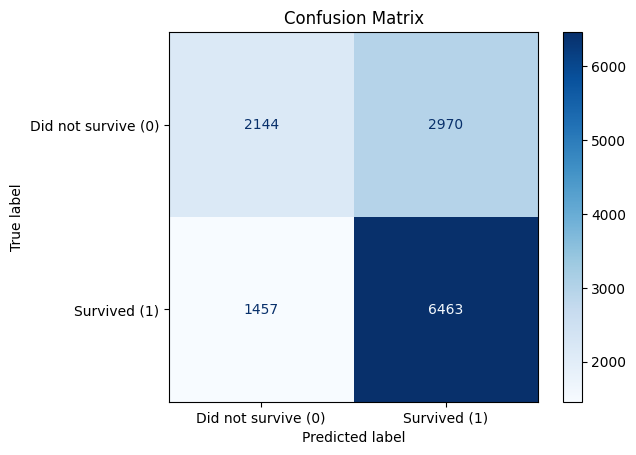

<Figure size 700x600 with 0 Axes>

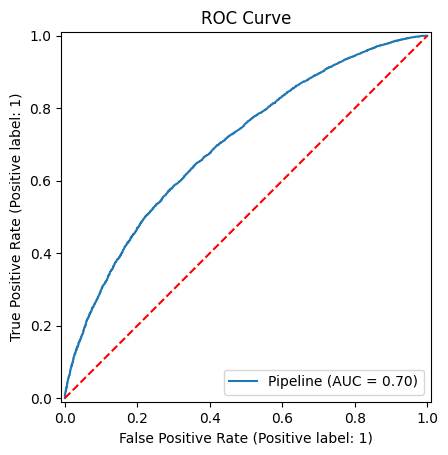

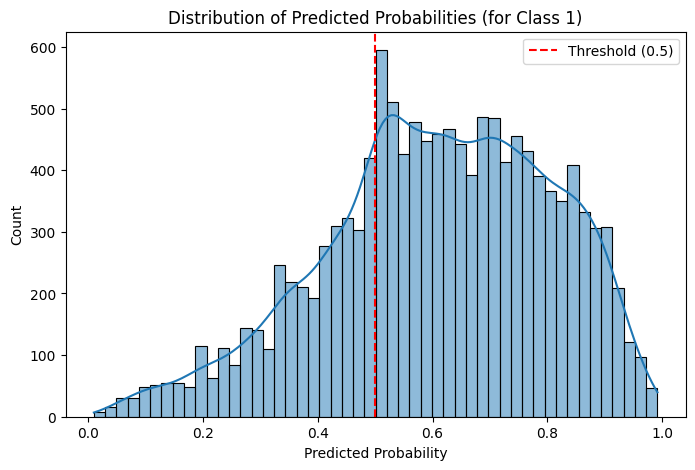


--- Top 20 Feature Importances ---
                          feature  importance
4         zip_median_business_age        0.04
0                     price_range        0.03
58          Indian_median_age_zip        0.02
52         Dessert_median_age_zip        0.02
63         Mexican_median_age_zip        0.02
126                  subtype_Cafe        0.02
59         Italian_median_age_zip        0.02
60        Japanese_median_age_zip        0.02
62   Mediterranean_median_age_zip        0.02
48        American_median_age_zip        0.01
127               subtype_Chinese        0.01
50            Cafe_median_age_zip        0.01
64           Pizza_median_age_zip        0.01
49       Breakfast_median_age_zip        0.01
130             subtype_Fast Food        0.01
57           Greek_median_age_zip        0.01
61          Korean_median_age_zip        0.01
134                subtype_Indian        0.01
132               subtype_General        0.01
68      Vietnamese_median_age_zip        0.0

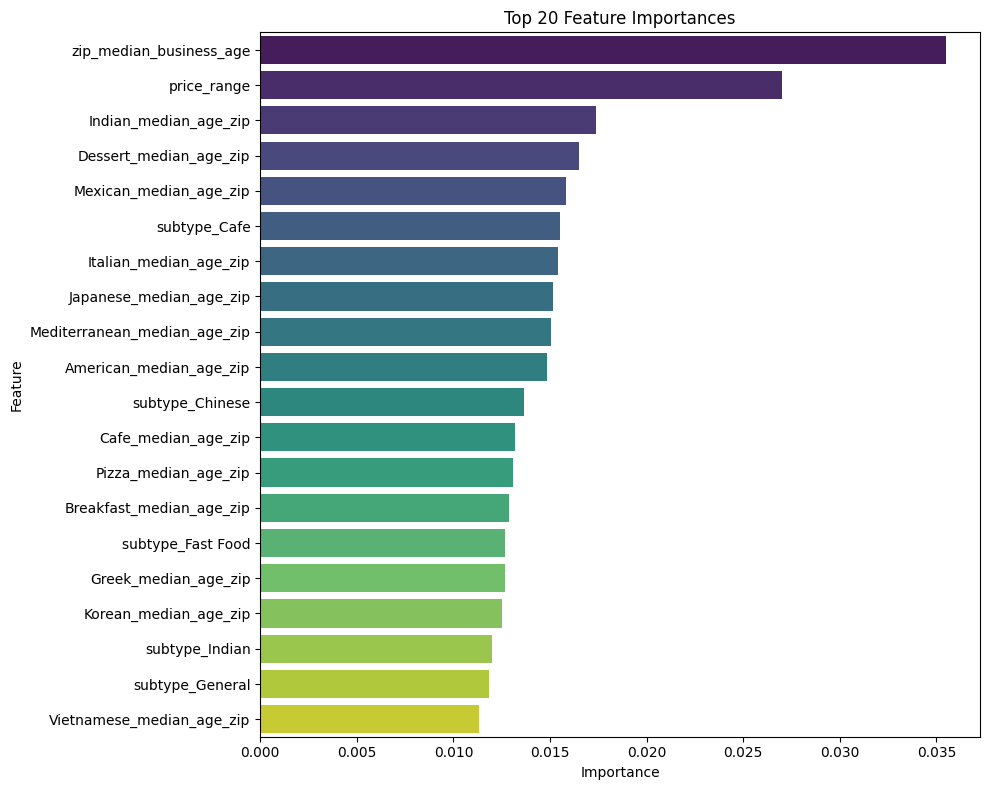


✓ Training complete! Run the next cell to save the model.


In [26]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, ConfusionMatrixDisplay, RocCurveDisplay
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore', category=UserWarning)

print("--- Running XGBoost Baseline Model (with zip_code as categorical) ---")

# --- 1. Load Data ---
if 'df_final' not in locals():
    print("\nERROR: `df_final` not found. Please load or create it first.")
else:
    print(f"Loaded df_final with shape: {df_final.shape}")

    # --- 2. Define Features (X) and Target (y) ---
    TARGET_COL = 'five_year_survivor'

    if TARGET_COL not in df_final.columns:
        print(f"\nERROR: Target column '{TARGET_COL}' not found in DataFrame.")
    else:
        y = df_final[TARGET_COL]
        X = df_final.drop(columns=[TARGET_COL])

        print(f"Target variable distribution (y):\n{y.value_counts(normalize=True)}")

        # --- 3. Identify Categorical and Numerical Features ---
        categorical_features = ['subtype', 'zip_code']
        numerical_features = [col for col in X.columns if col not in categorical_features]

        print(f"\nIdentified {len(categorical_features)} categorical features: {categorical_features}")
        print(f"Identified {len(numerical_features)} numerical features.")

        # --- 4. Create Preprocessing Pipeline ---
        preprocessor = ColumnTransformer(
            transformers=[
                ('num', 'passthrough', numerical_features),
                ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features)
            ],
            remainder='drop'
        )

        # --- 5. Create XGBoost Model Pipeline ---
        model_pipeline = Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('model', xgb.XGBClassifier(objective='binary:logistic',
                                         eval_metric='logloss',
                                         use_label_encoder=False,
                                         random_state=42))
        ])

        # --- 6. Split the Data ---
        X_train, X_test, y_train, y_test = train_test_split(
            X, y,
            test_size=0.2,
            random_state=42,
            stratify=y
        )
        print(f"\nSplit data into {len(X_train)} training and {len(X_test)} test samples.")

        # --- 7. Train the Model ---
        print("Training the XGBoost model...")
        model_pipeline.fit(X_train, y_train)
        print("Model training complete.")

        # --- 8. Make Predictions ---
        y_pred = model_pipeline.predict(X_test)
        y_pred_proba = model_pipeline.predict_proba(X_test)[:, 1]

        # --- 9. Evaluate the Model ---
        print("\n--- Model Evaluation (Test Set) ---")

        accuracy = accuracy_score(y_test, y_pred)
        roc_auc = roc_auc_score(y_test, y_pred_proba)
        cm = confusion_matrix(y_test, y_pred)

        print(f"Accuracy:  {accuracy:.4f}")
        print(f"ROC AUC:   {roc_auc:.4f}")

        print("\nClassification Report:")
        print(classification_report(y_test, y_pred, target_names=['Did not survive (0)', 'Survived (1)']))

        print("\nConfusion Matrix:")
        print(cm)

        # --- 9b. Visualizations ---
        print("\n--- Generating Evaluation Plots ---")

        # Plot 1: Confusion Matrix Heatmap
        try:
            plt.figure(figsize=(6, 5))
            disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Did not survive (0)', 'Survived (1)'])
            disp.plot(cmap='Blues')
            plt.title('Confusion Matrix')
            plt.grid(False)
            plt.show()
        except Exception as e:
            print(f"Could not plot Confusion Matrix: {e}")

        # Plot 2: ROC Curve
        try:
            plt.figure(figsize=(7, 6))
            RocCurveDisplay.from_estimator(model_pipeline, X_test, y_test)
            plt.title('ROC Curve')
            plt.plot([0, 1], [0, 1], 'r--')
            plt.show()
        except Exception as e:
            print(f"Could not plot ROC Curve: {e}")

        # Plot 3: Distribution of Predicted Probabilities
        try:
            plt.figure(figsize=(8, 5))
            sns.histplot(y_pred_proba, bins=50, kde=True)
            plt.title('Distribution of Predicted Probabilities (for Class 1)')
            plt.xlabel('Predicted Probability')
            plt.ylabel('Count')
            plt.axvline(0.5, color='red', linestyle='--', label='Threshold (0.5)')
            plt.legend()
            plt.show()
        except Exception as e:
            print(f"Could not plot probability distribution: {e}")

        # --- 10. Feature Importances ---
        print("\n--- Top 20 Feature Importances ---")

        try:
            ohe_feature_names = model_pipeline.named_steps['preprocessor'] \
                                .named_transformers_['cat'] \
                                .get_feature_names_out(categorical_features)

            all_feature_names = numerical_features + list(ohe_feature_names)
            importances = model_pipeline.named_steps['model'].feature_importances_

            feature_importance_df = pd.DataFrame({
                'feature': all_feature_names,
                'importance': importances
            }).sort_values(by='importance', ascending=False)

            print(feature_importance_df.head(20))

            # Plot 4: Feature Importance Bar Chart
            try:
                top_20_features = feature_importance_df.head(20)
                plt.figure(figsize=(10, 8))
                sns.barplot(x='importance', y='feature', data=top_20_features, palette='viridis')
                plt.title('Top 20 Feature Importances')
                plt.xlabel('Importance')
                plt.ylabel('Feature')
                plt.tight_layout()
                plt.show()
            except Exception as e:
                print(f"Could not plot feature importances: {e}")

        except Exception as e:
            print(f"Could not retrieve feature importances: {e}")

print("\n" + "="*60)
print("✓ Training complete! Run the next cell to save the model.")
print("="*60)

In [27]:
# --- SAVE THE TRAINED MODEL ---
print("="*60)
print("--- SAVING TRAINED MODEL ---")
print("="*60)

# Check if model exists
if 'model_pipeline' not in globals():
    print("✗ ERROR: model_pipeline not found!")
    print("Please run the training cell above first.")
else:
    import joblib
    import sklearn
    import os

    print(f"scikit-learn version: {sklearn.__version__}")

    # Verify model is trained
    try:
        _ = model_pipeline.predict(X_train.iloc[:1])
        print("✓ Model is trained and ready")
    except:
        print("✗ ERROR: Model is not trained!")
        print("Run the training cell above first.")
        raise

    # Save with joblib (better for sklearn objects)
    file_path = 'xgboost_untuned_model.pkl'
    joblib.dump(model_pipeline, file_path, compress=3)

    # Show file info
    file_size_mb = os.path.getsize(file_path) / (1024 * 1024)
    print(f"✓ Saved model to: {file_path}")
    print(f"✓ File size: {file_size_mb:.2f} MB")

    # Download it
    from google.colab import files
    files.download(file_path)
    print("✓ Download started!")

print("="*60)

--- SAVING TRAINED MODEL ---
scikit-learn version: 1.7.2
✓ Model is trained and ready
✓ Saved model to: xgboost_untuned_model.pkl
✓ File size: 0.11 MB


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✓ Download started!


### With Hyperparamter Tuning

In [28]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, ConfusionMatrixDisplay, RocCurveDisplay
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore', category=UserWarning)

print("--- Running XGBoost Tuned Model (with RandomizedSearchCV) ---")

# --- 1. Load Data ---
if 'df_final' not in locals():
    print("\nERROR: `df_final` not found. Please load or create it first.")
else:
    print(f"Loaded df_final with shape: {df_final.shape}")

    # --- 2. Define Features (X) and Target (y) ---
    TARGET_COL = 'five_year_survivor'

    if TARGET_COL not in df_final.columns:
        print(f"\nERROR: Target column '{TARGET_COL}' not found in DataFrame.")
    else:
        y = df_final[TARGET_COL]
        X = df_final.drop(columns=[TARGET_COL])

        print(f"Target variable distribution (y):\n{y.value_counts(normalize=True)}")

        # --- 3. Identify Categorical and Numerical Features ---
        categorical_features = ['subtype', 'zip_code']
        numerical_features = [col for col in X.columns if col not in categorical_features]

        print(f"\nIdentified {len(categorical_features)} categorical features: {categorical_features}")
        print(f"Identified {len(numerical_features)} numerical features.")

        # --- 4. Create Preprocessing Pipeline ---
        preprocessor = ColumnTransformer(
            transformers=[
                ('num', 'passthrough', numerical_features),
                ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features)
            ],
            remainder='drop'
        )

        # --- 5. Create XGBoost Model Pipeline ---
        # This is the base pipeline that RandomizedSearchCV will use
        model_pipeline = Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('model', xgb.XGBClassifier(objective='binary:logistic',
                                         eval_metric='logloss',
                                         use_label_encoder=False,
                                         random_state=42))
        ])

        # --- 5b. Define Hyperparameter Distribution ---
        # Note: 'model__' prefix is used to target steps in the pipeline
        param_dist = {
            'model__n_estimators': [100, 200, 300, 400],
            'model__learning_rate': [0.01, 0.05, 0.1, 0.2],
            'model__max_depth': [3, 5, 7, 9],
            'model__colsample_bytree': [0.7, 0.8, 0.9, 1.0],
            'model__subsample': [0.7, 0.8, 0.9, 1.0],
            'model__gamma': [0, 0.1, 0.2]
        }

        # --- 6. Split the Data ---
        X_train, X_test, y_train, y_test = train_test_split(
            X, y,
            test_size=0.2,
            random_state=42,
            stratify=y
        )
        print(f"\nSplit data into {len(X_train)} training and {len(X_test)} test samples.")

        # --- 7. Set up RandomizedSearchCV ---
        # We'll use 'roc_auc' for scoring as it's good for imbalanced classes
        # n_iter controls how many combinations to try (e.g., 25)
        # cv is the number of cross-validation folds (e.g., 3 or 5)
        # n_jobs=-1 uses all available CPU cores
        print("Setting up RandomizedSearchCV...")
        random_search = RandomizedSearchCV(
            estimator=model_pipeline,
            param_distributions=param_dist,
            n_iter=25,  # Number of parameter settings that are sampled.
            scoring='roc_auc',
            cv=3,       # Number of cross-validation folds
            random_state=42,
            n_jobs=-1,
            verbose=2  # Set to 2 or 3 for more output during training
        )

        # --- 8. Train the Tuned Model ---
        print("Training the tuned XGBoost model (this may take several minutes)...")
        random_search.fit(X_train, y_train)
        print("Model training complete.")

        print("\n--- Best Hyperparameters Found ---")
        print(random_search.best_params_)
        print(f"\nBest cross-validation ROC AUC: {random_search.best_score_:.4f}")

        # The best_estimator_ is the model refitted on the full training set
        best_model = random_search.best_estimator_

        # --- 9. Make Predictions with Best Model ---
        y_pred = best_model.predict(X_test)
        y_pred_proba = best_model.predict_proba(X_test)[:, 1]

        # --- 10. Evaluate the Best Model ---
        print("\n--- Tuned Model Evaluation (Test Set) ---")

        accuracy = accuracy_score(y_test, y_pred)
        roc_auc = roc_auc_score(y_test, y_pred_proba)
        cm = confusion_matrix(y_test, y_pred)

        print(f"Accuracy:  {accuracy:.4f}")
        print(f"ROC AUC:   {roc_auc:.4f}")

        print("\nClassification Report:")
        print(classification_report(y_test, y_pred, target_names=['Did not survive (0)', 'Survived (1)']))

        print("\nConfusion Matrix:")
        print(cm)

        # --- 11. Visualizations ---
        print("\n--- Generating Evaluation Plots for Tuned Model ---")

        # Plot 1: Confusion Matrix Heatmap
        try:
            plt.figure(figsize=(6, 5))
            disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Did not survive (0)', 'Survived (1)'])
            disp.plot(cmap='Blues')
            plt.title('Tuned Model Confusion Matrix')
            plt.grid(False)
            plt.show()
        except Exception as e:
            print(f"Could not plot Confusion Matrix: {e}")

        # Plot 2: ROC Curve
        try:
            plt.figure(figsize=(7, 6))
            # Use random_search (which uses best_estimator_) to plot
            RocCurveDisplay.from_estimator(random_search, X_test, y_test)
            plt.title('Tuned Model ROC Curve')
            plt.plot([0, 1], [0, 1], 'r--')
            plt.show()
        except Exception as e:
            print(f"Could not plot ROC Curve: {e}")

        # Plot 3: Distribution of Predicted Probabilities
        try:
            plt.figure(figsize=(8, 5))
            sns.histplot(y_pred_proba, bins=50, kde=True)
            plt.title('Tuned Model - Distribution of Predicted Probabilities (for Class 1)')
            plt.xlabel('Predicted Probability')
            plt.ylabel('Count')
            plt.axvline(0.5, color='red', linestyle='--', label='Threshold (0.5)')
            plt.legend()
            plt.show()
        except Exception as e:
            print(f"Could not plot probability distribution: {e}")

        # --- 12. Feature Importances ---
        print("\n--- Top 20 Feature Importances (Tuned Model) ---")

        try:
            ohe_feature_names = best_model.named_steps['preprocessor'] \
                                .named_transformers_['cat'] \
                                .get_feature_names_out(categorical_features)

            all_feature_names = numerical_features + list(ohe_feature_names)
            importances = best_model.named_steps['model'].feature_importances_

            feature_importance_df = pd.DataFrame({
                'feature': all_feature_names,
                'importance': importances
            }).sort_values(by='importance', ascending=False)

            print(feature_importance_df.head(20))

            # Plot 4: Feature Importance Bar Chart
            try:
                top_20_features = feature_importance_df.head(20)
                plt.figure(figsize=(10, 8))
                sns.barplot(x='importance', y='feature', data=top_20_features, palette='viridis')
                plt.title('Tuned Model - Top 20 Feature Importances')
                plt.xlabel('Importance')
                plt.ylabel('Feature')
                plt.tight_layout()
                plt.show()
            except Exception as e:
                print(f"Could not plot feature importances: {e}")

        except Exception as e:
            print(f"Could not retrieve feature importances: {e}")

--- Running XGBoost Tuned Model (with RandomizedSearchCV) ---
Loaded df_final with shape: (65168, 127)
Target variable distribution (y):
five_year_survivor
1   0.61
0   0.39
Name: proportion, dtype: float64

Identified 2 categorical features: ['subtype', 'zip_code']
Identified 124 numerical features.

Split data into 52134 training and 13034 test samples.
Setting up RandomizedSearchCV...
Training the tuned XGBoost model (this may take several minutes)...
Fitting 3 folds for each of 25 candidates, totalling 75 fits


KeyboardInterrupt: 